# Chapter 19 - Exercises

In [1]:
library(tidyverse)
library(bayesrules)
library(bayesplot)
library(rstan)
library(rstanarm)
library(broom.mixed)
library(tidybayes)
library(forcats)
options(mc.cores = parallel::detectCores())

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: StanHeaders

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recomp

## Exercise 19.1

Is there a book-level? I.e. are the characteristics of the book always the same, regardless of state and challenge?

Note that there are sometimes multiple challenges per state:

In [2]:
book_banning %>% filter( title  %in% "A Separate Reality" )

title              book_id author            date       year removed explicit
1 A Separate Reality 46      Castaneda, Carlos 2001-05-25 2001 0       0       
2 A Separate Reality 46      Casteneda, Carlos 2000-06-29 2000 0       0       
  antifamily occult language lgbtq violent state political_value_index
1 0          0      0        0     0       OR    4                    
2 0          0      0        0     0       OR    4                    
  median_income hs_grad_rate college_grad_rate
1 1274.5        5.538042     1.07627          
2 1274.5        5.538042     1.07627

In [3]:
book_banning %>% filter( title  %in% "Always Running" )

title          book_id author          date       year removed explicit
1 Always Running 118     Rodriguez, Luis 2004-09-01 2004 1       1       
2 Always Running 118     Rodriguez, Luis 2004-12-05 2004 1       1       
3 Always Running 118     Rodriguez, Luis 2004-10-15 2004 1       1       
  antifamily occult language lgbtq violent state political_value_index
1 1          0      1        0     1       CA    7.4                  
2 0          0      0        0     1       CA    7.4                  
3 0          0      0        0     1       CA    7.4                  
  median_income hs_grad_rate college_grad_rate
1 10119         -2.761958    2.57627          
2 10119         -2.761958    2.57627          
3 10119         -2.761958    2.57627

Are book IDs mapped to title in unique way? In other words can multiple book IDs be assigned to the same title? Can the same title be assigned to the same book ID?

There is only one book ID for a given title.

In [4]:
book_banning %>% count(book_id, title) %>% count( title ) %>% filter(n > 1)

title n

However there are multiple titles assigned to the same book ID:

In [5]:
book_banning %>% count(book_id, title) %>% count( book_id ) %>% filter(n > 1) %>% head()

book_id n
1 100     2
2 148     2
3 356     3
4 717     2
5 722     2
6 724     2

Some examples:

In [6]:
book_banning  %>% filter( book_id==100 ) %>% select( title, book_id, author, date )

title            book_id author                   date      
1 Alice on Her Way 100     Naylor, Phyllis Reynolds 2007-09-08
2 Alice On Her Way 100     Naylor, Phyllis Reynolds 2009-11-09

In [7]:
book_banning  %>% filter( book_id==148 ) %>% select( title, book_id, author, date )

title                                    book_id author           date      
1 Angus, Thongs, and Full Frontal Snogging 148     Rennison, Louise 2005-04-01
2 Angus, Thongs, and Full Frontal Snogging 148     Rennison, Louise 2003-12-11
3 Knocked Out By My Nunga-Nungas           148     Rennison, Louise 2007-07-22
4 Angus, Thongs, and Full Frontal Snogging 148     Rennison, Louise 2004-04-09
5 Angus, Thongs, and Full Frontal Snogging 148     Rennison, Louise 2009-11-22
6 Angus, Thongs, and Full Frontal Snogging 148     Rennison, Louise 2006-07-15

In [8]:
book_banning  %>% filter( book_id==356 ) %>% select( title, book_id, author, date )

title                                                            book_id
1 Captain Underpants                                               356    
2 Captain Underpants (series)                                      356    
3 Captain Underpants and the Perilous Plot of Professor Poopypants 356    
  author      date      
1 Pilkey, Dav 2010-08-12
2 Pilkey, Dav 2005-06-09
3 Pilkey, Dav 2002-06-24

The titles are different, but seem more or less the same for the same book ID, however this would need to be investigated more closely.

Are the book characteristics explicit, antifamily, occult, language, lgbtq and violent the same for all book challenges in a given state? To check this, compute the mean of all these variables grouped by state and book id. If the mean is different from 0 or 1, then the values per book are different. This appears not to be the case, so we can speak of a book-level that is a sublevel of state-level.

In [9]:
book_banning %>% 
    select( state, book_id, explicit:violent ) %>% 
    group_by( state, book_id ) %>% 
    summarize_all( \(x) { mean(as.numeric(x)-1) } ) %>% 
    filter_at( vars(explicit:violent), \(x) { !(x  %in%  c(1,0))} )

state book_id explicit antifamily occult language lgbtq violent

It remains to check, whether the state-level predictors are really only on the state-level. To that end, check whether the variance of any of the predictors is larger than zero:

In [10]:
book_banning %>% 
    select( state, political_value_index, median_income, hs_grad_rate, college_grad_rate ) %>% 
    group_by( state ) %>% 
    summarize_all( var ) %>% 
    filter_at( vars(political_value_index:college_grad_rate), \(x) {x>0})

state political_value_index median_income hs_grad_rate college_grad_rate

## Exercise 19.2

Check whether peak-level predictors do not vary from peak to peak:

In [11]:
climbers_sub %>% 
    select( peak_id, height_metres, first_ascent_year ) %>% 
    group_by( peak_id ) %>% 
    summarize_all( var ) %>% 
    filter_at( vars(height_metres:first_ascent_year), \(x) !(x %in% c(0,NA)) )

peak_id height_metres first_ascent_year

Check whether expedition-level predictors do not vary from expedition to expedition (sublevel of peak level):

In [12]:
climbers_sub %>% 
    group_by( peak_id, expedition_id ) %>% 
    summarize( var_count = var(count) ) %>% 
    filter( var_count > 0 )

`summarise()` has grouped output by 'peak_id'. You can override using the
`.groups` argument.


peak_id expedition_id var_count

Check whether climber-level predictors do not vary from climber to climber (sublevel of expedition level):

In [13]:
climbers_sub %>% 
    select( peak_id, expedition_id, member_id, age, expedition_role ) %>% 
    group_by( peak_id, expedition_id, member_id ) %>% 
    summarize( count=n() ) %>% 
    filter( count>1 )

`summarise()` has grouped output by 'peak_id', 'expedition_id'. You can
override using the `.groups` argument.


peak_id expedition_id member_id count

No multiple entries for the same climber, so no variance.

## Exercise 19.5

In [14]:
spotify_small <- spotify %>% 
      filter(artist %in% c("Beyoncé", "Camila Cabello", "Camilo",
                           "Frank Ocean", "J. Cole", "Kendrick Lamar")) %>% 
      select(artist, album_id, popularity, valence)

head( spotify_small )

artist  album_id               popularity valence
1 Beyoncé 7dK54iZuOxXFarGhXwEXfF 75         55.2   
2 Beyoncé 39P7VD7qlg3Z0ltq60eHp7 77         47.2   
3 Beyoncé 1gIC63gC3B7o7FfpPACZQJ 75         76.0   
4 Beyoncé 1gIC63gC3B7o7FfpPACZQJ 75         76.0   
5 Beyoncé 20E3PwDg1jaDdK9K565luD 66         47.2   
6 Beyoncé 0Zd10MKN5j9KwUST0TdBBB 72         50.9

In [15]:
dim( spotify_small )

[1] 155   4

### a)

`album_id` is the second grouping variable. Usually, an artist produces multiple albums with multiple songs each, so we deal with a nested model. Multiple artists can participate in an album, but then it appears to be clearly defined by providing a list in the artist field.

### b)

artists 

$\to$ Beyoncé, Camila Cabello, Camilo, .. 

$\to$ Album 1 of Beyoncé, Album 2 of Beyoncé, .., Album 1 of Camila Cabello, .. 

$\to$ Song 1 of Album 1 of Beyoncé, .., Song 10 of Album 1 of Beyoncé, .., Song 1 of Album 1 of Camila Cabello, ..

Thus a nested structure with artists $\to$ albums $\to$ songs.

### c)

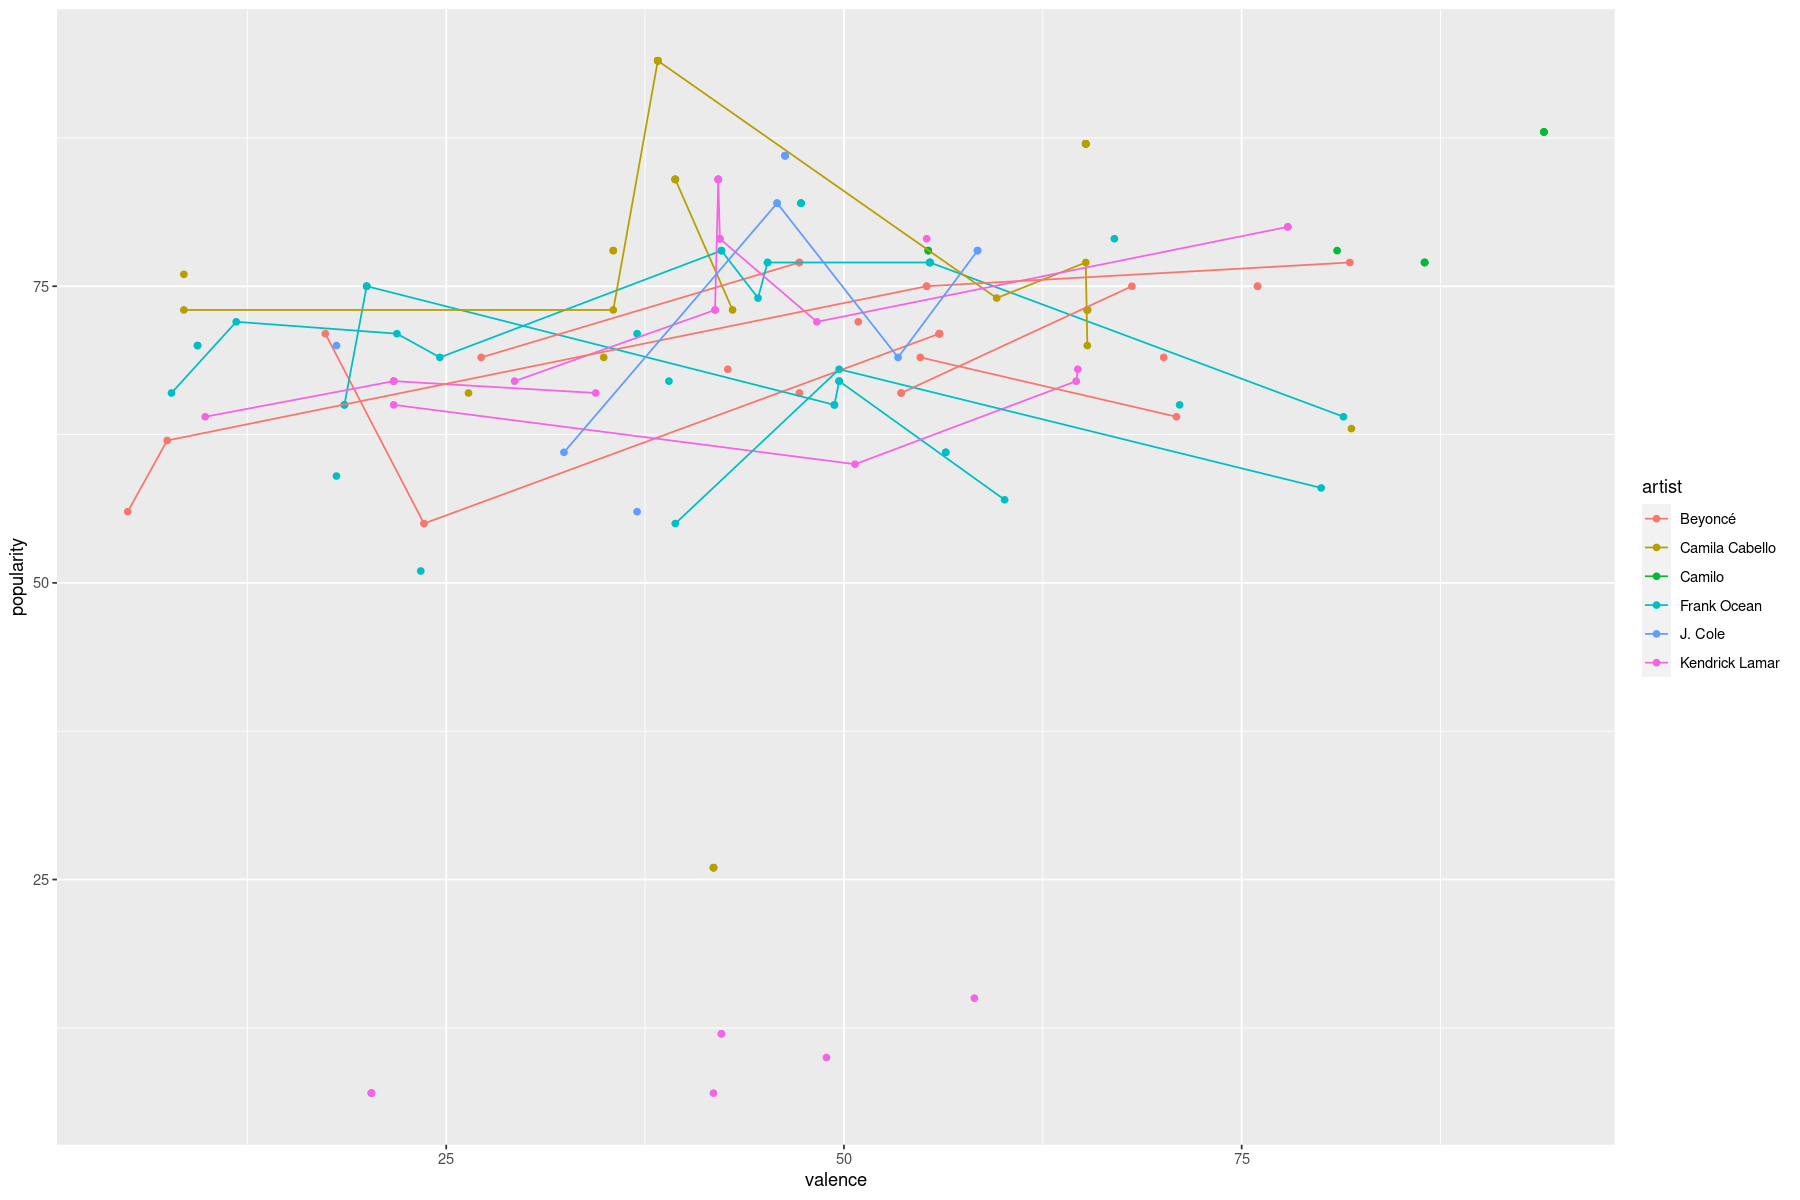

In [16]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot( spotify_small, aes(x=valence, y=popularity, color=artist) ) + 
    geom_point() +
    geom_line( aes(group=album_id, color=artist) )

Maybe not the nicest plot: Points represent individual songs, connected points indicate songs on the same album and colors represents artists. It appears that the variability within the songs of an individual album of an artist is smaller than the overall variability of songs/albums of an artist.

## Exercise 19.6

### a)

$$Y_{ij} | \beta_{0j}, \beta_1, \sigma_y \sim N(\mu_{ij}, \sigma_y^2), \quad \text{with } \mu_{ij} = \beta_{0j} + \beta_1 X_{ij}$$ 

$$\beta_{0j}|\beta_0, \sigma_0 \sim N(\beta_0, \sigma_0^2)$$

$$\beta_{0c}\sim N(m_0, s_0^2)$$

$$\beta_{1}\sim N(0, s_1^2)$$

$$\sigma_y \sim \text{Exp}(l_y)$$

$$\sigma_0 \sim \text{Exp}(l_0)$$

where $X_{ij}$ and $Y_{ij}$ stands for the valence and popularity for song $i$ of artist $j$. $\beta_{0j}$ represents the different baseline popularities for the different artists, $\sigma_y$ the variability within the popularity of songs of an artist and $\sigma_0$ the variability in popularity between artists. $\beta_1$ represents the global slope parameter for valence.

### b)

In [17]:
spotify_model_1 <- stan_glmer(
  popularity ~ valence + (1 | artist), 
  data = spotify_small, family = gaussian,
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

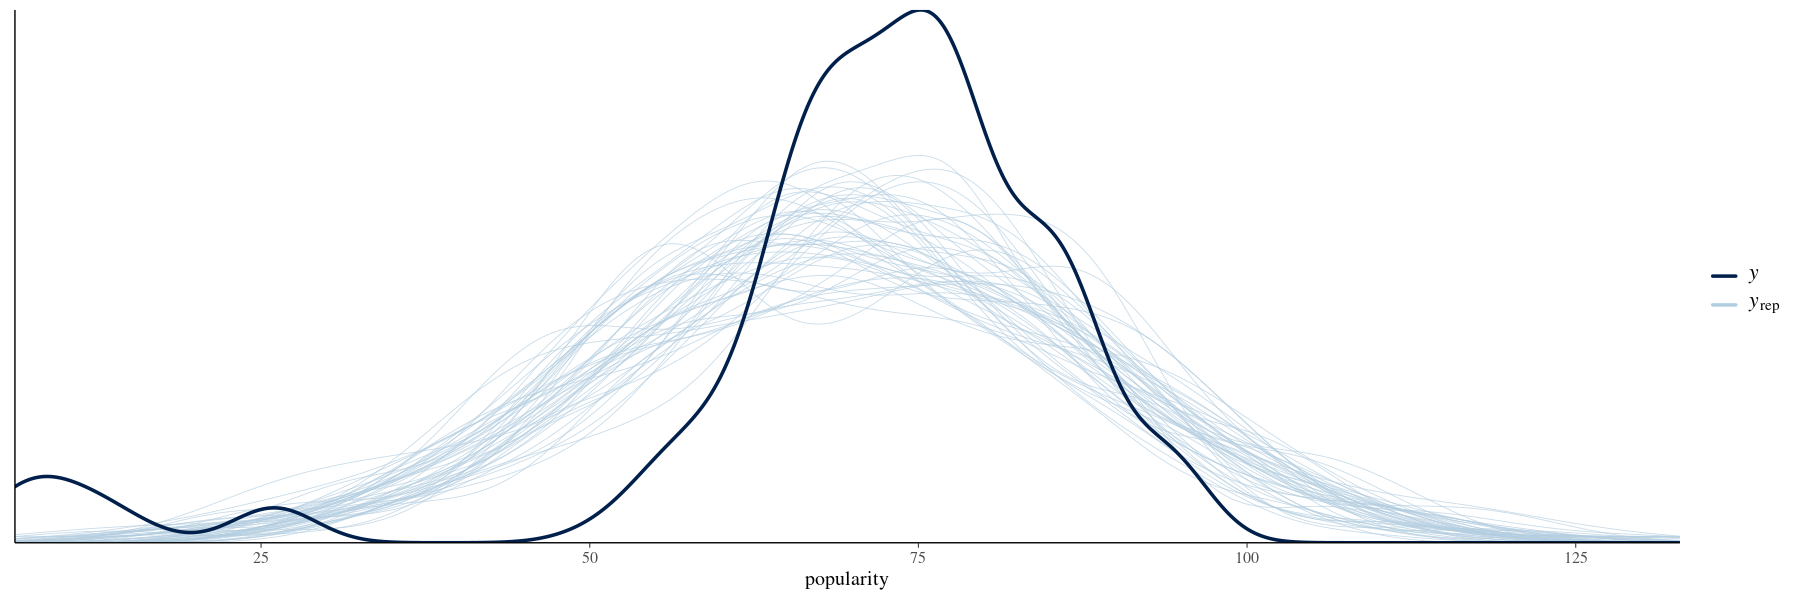

In [18]:
options(repr.plot.width=15, repr.plot.height=5)
pp_check(spotify_model_1) + xlab("popularity")

The model does not represent the measured data well! Adding album-level information might reduce the inductive bias of the model.

### c)

$$Y_{ijk} | \beta_{0}, b_{0j}, p_{0k}, \beta_1, \sigma_y \sim N(\mu_{ij}, \sigma_y^2), \quad \text{with } \mu_{ij} = \left(\beta_{0} + b_{0j} + p_{0k}\right) + \beta_1 X_{ijk}$$ 

$$b_{0j}|\sigma_b \sim N(0, \sigma_b^2)$$

$$p_{0k}|\sigma_p \sim N(0, \sigma_p^2)$$

$$\beta_{0c}\sim N(m_0, s_0^2)$$

$$\beta_{1}\sim N(0, s_1^2)$$

$$\sigma_y \sim \text{Exp}(l_y)$$

Here, $X_{ijk}$ and $Y_{ijk}$ stand for the valence and popularity for song $i$ in album $j$ of artist $k$. $b_{0j}$ represents the different baseline popularities for the different albums of an artist, $p_{0k}$ the different artists and $\sigma_y$ the variability within the popularity of songs of a particular album of a particular artist.$\beta_1$ represents the global slope parameter for valence.

### d)

In [19]:
spotify_model_2 <- stan_glmer(
  popularity ~ valence + (1 | album_id) + (1 | artist), 
  data = spotify_small, family = gaussian,
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

Warning message:
“There were 6 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


MCMC diagnostics:

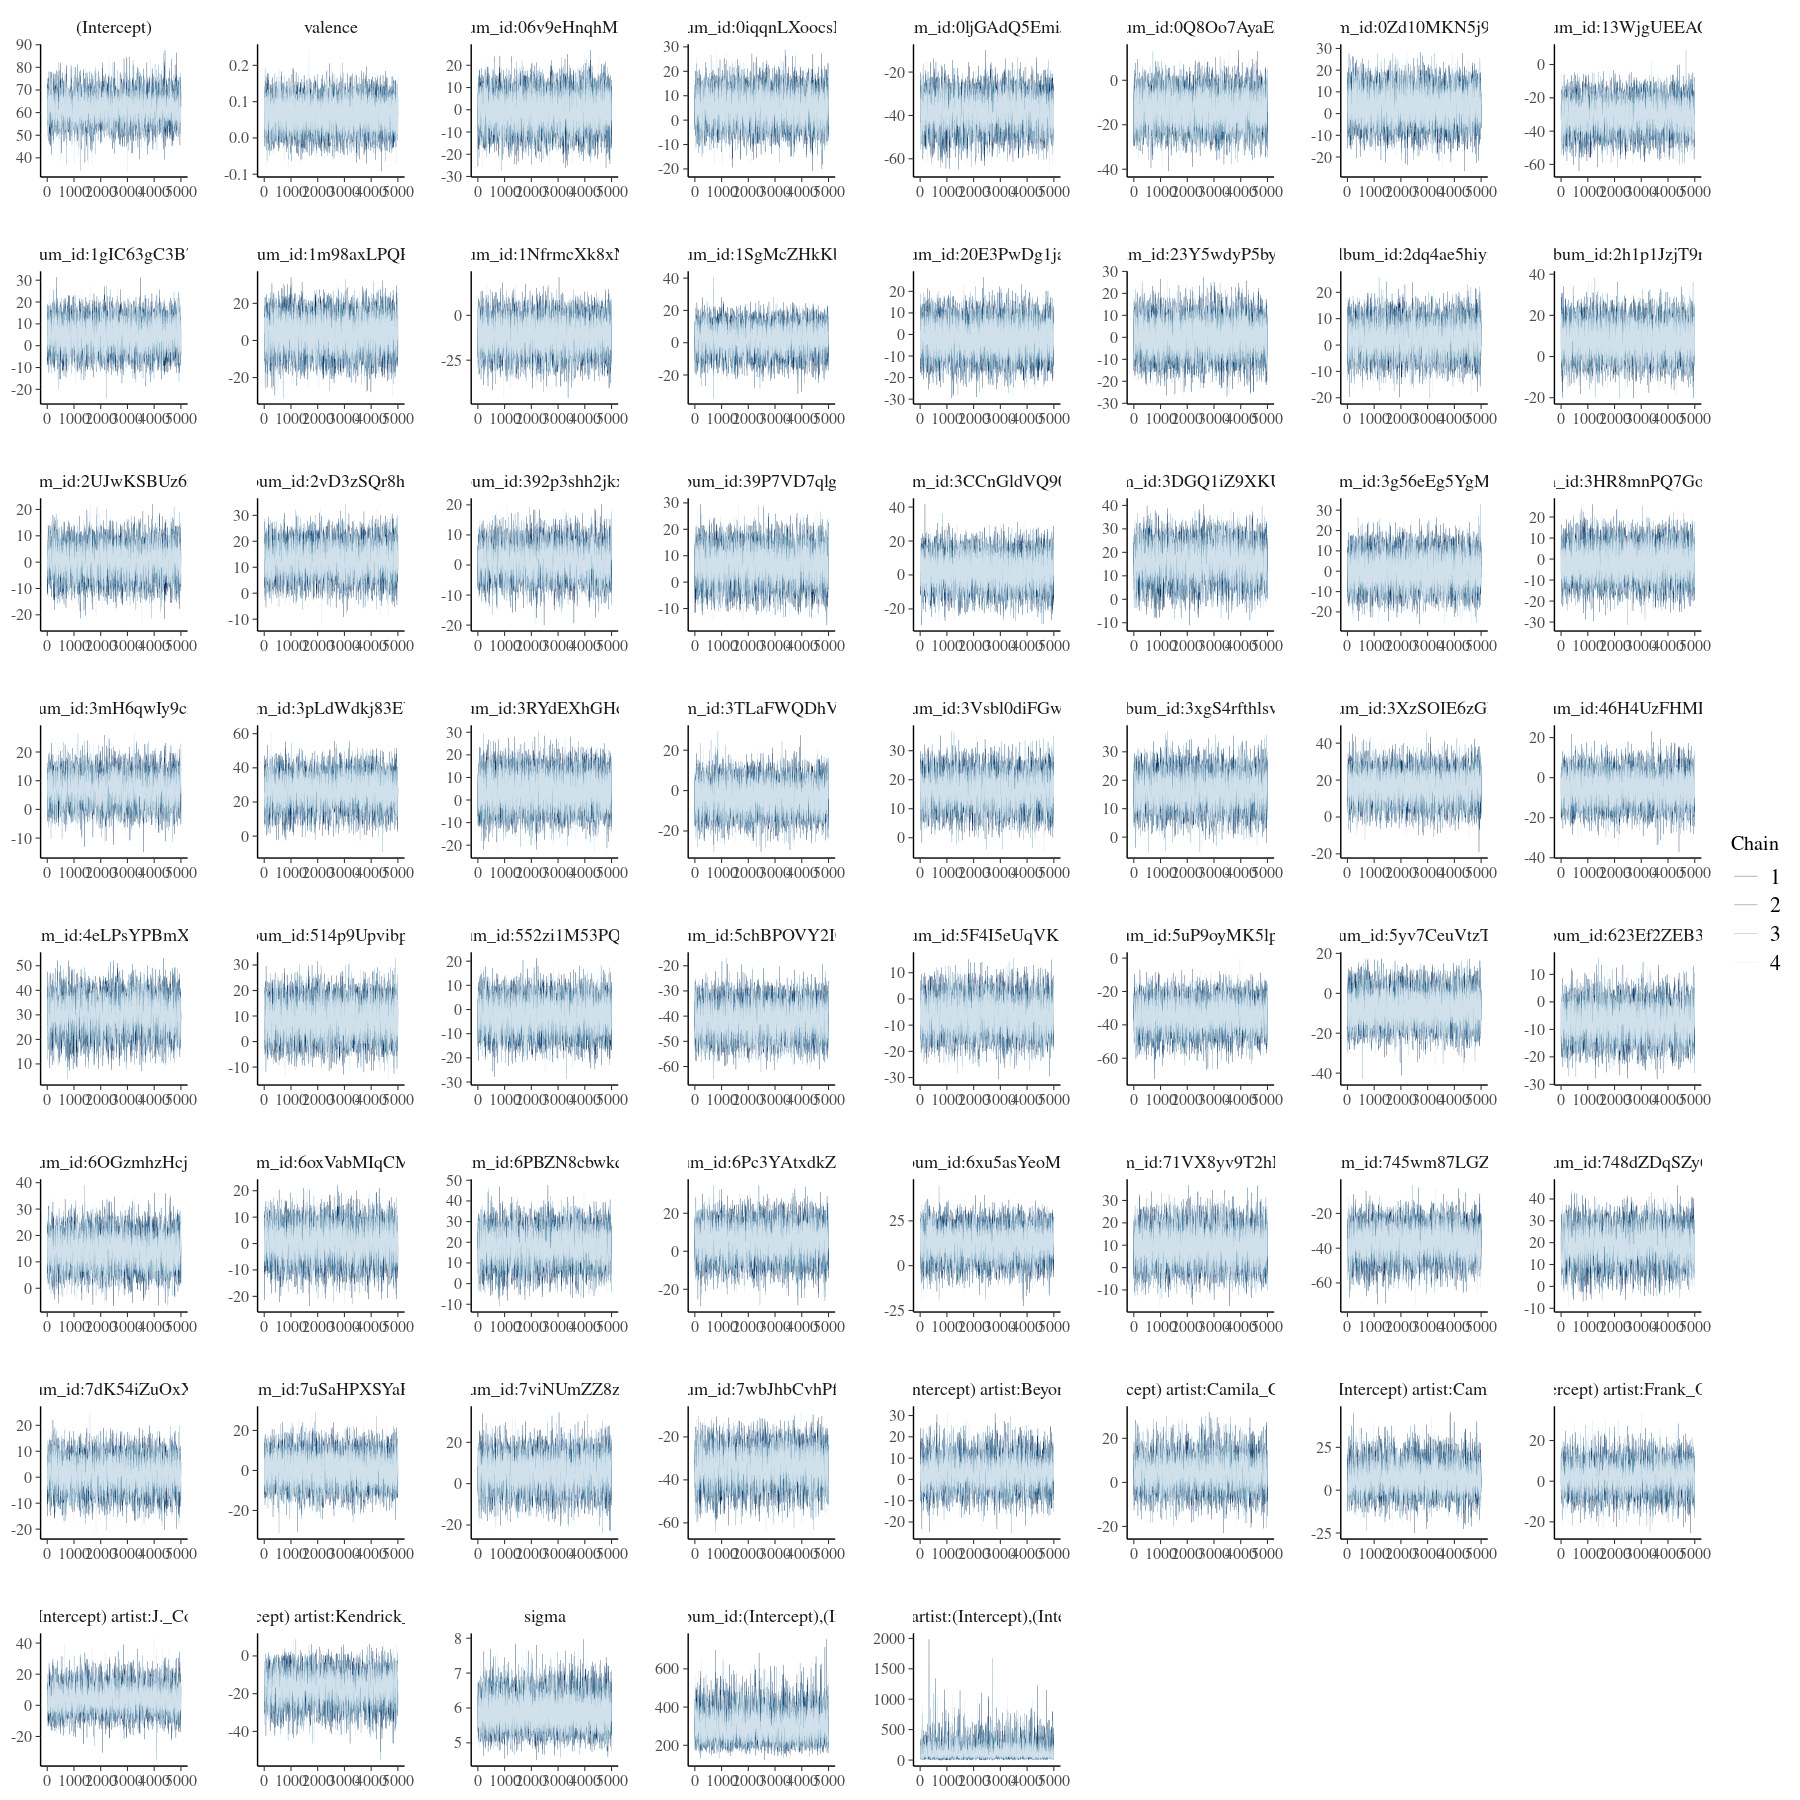

Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the bayesplot package.
  Please report the issue at <https://github.com/stan-dev/bayesplot/issues/>.”


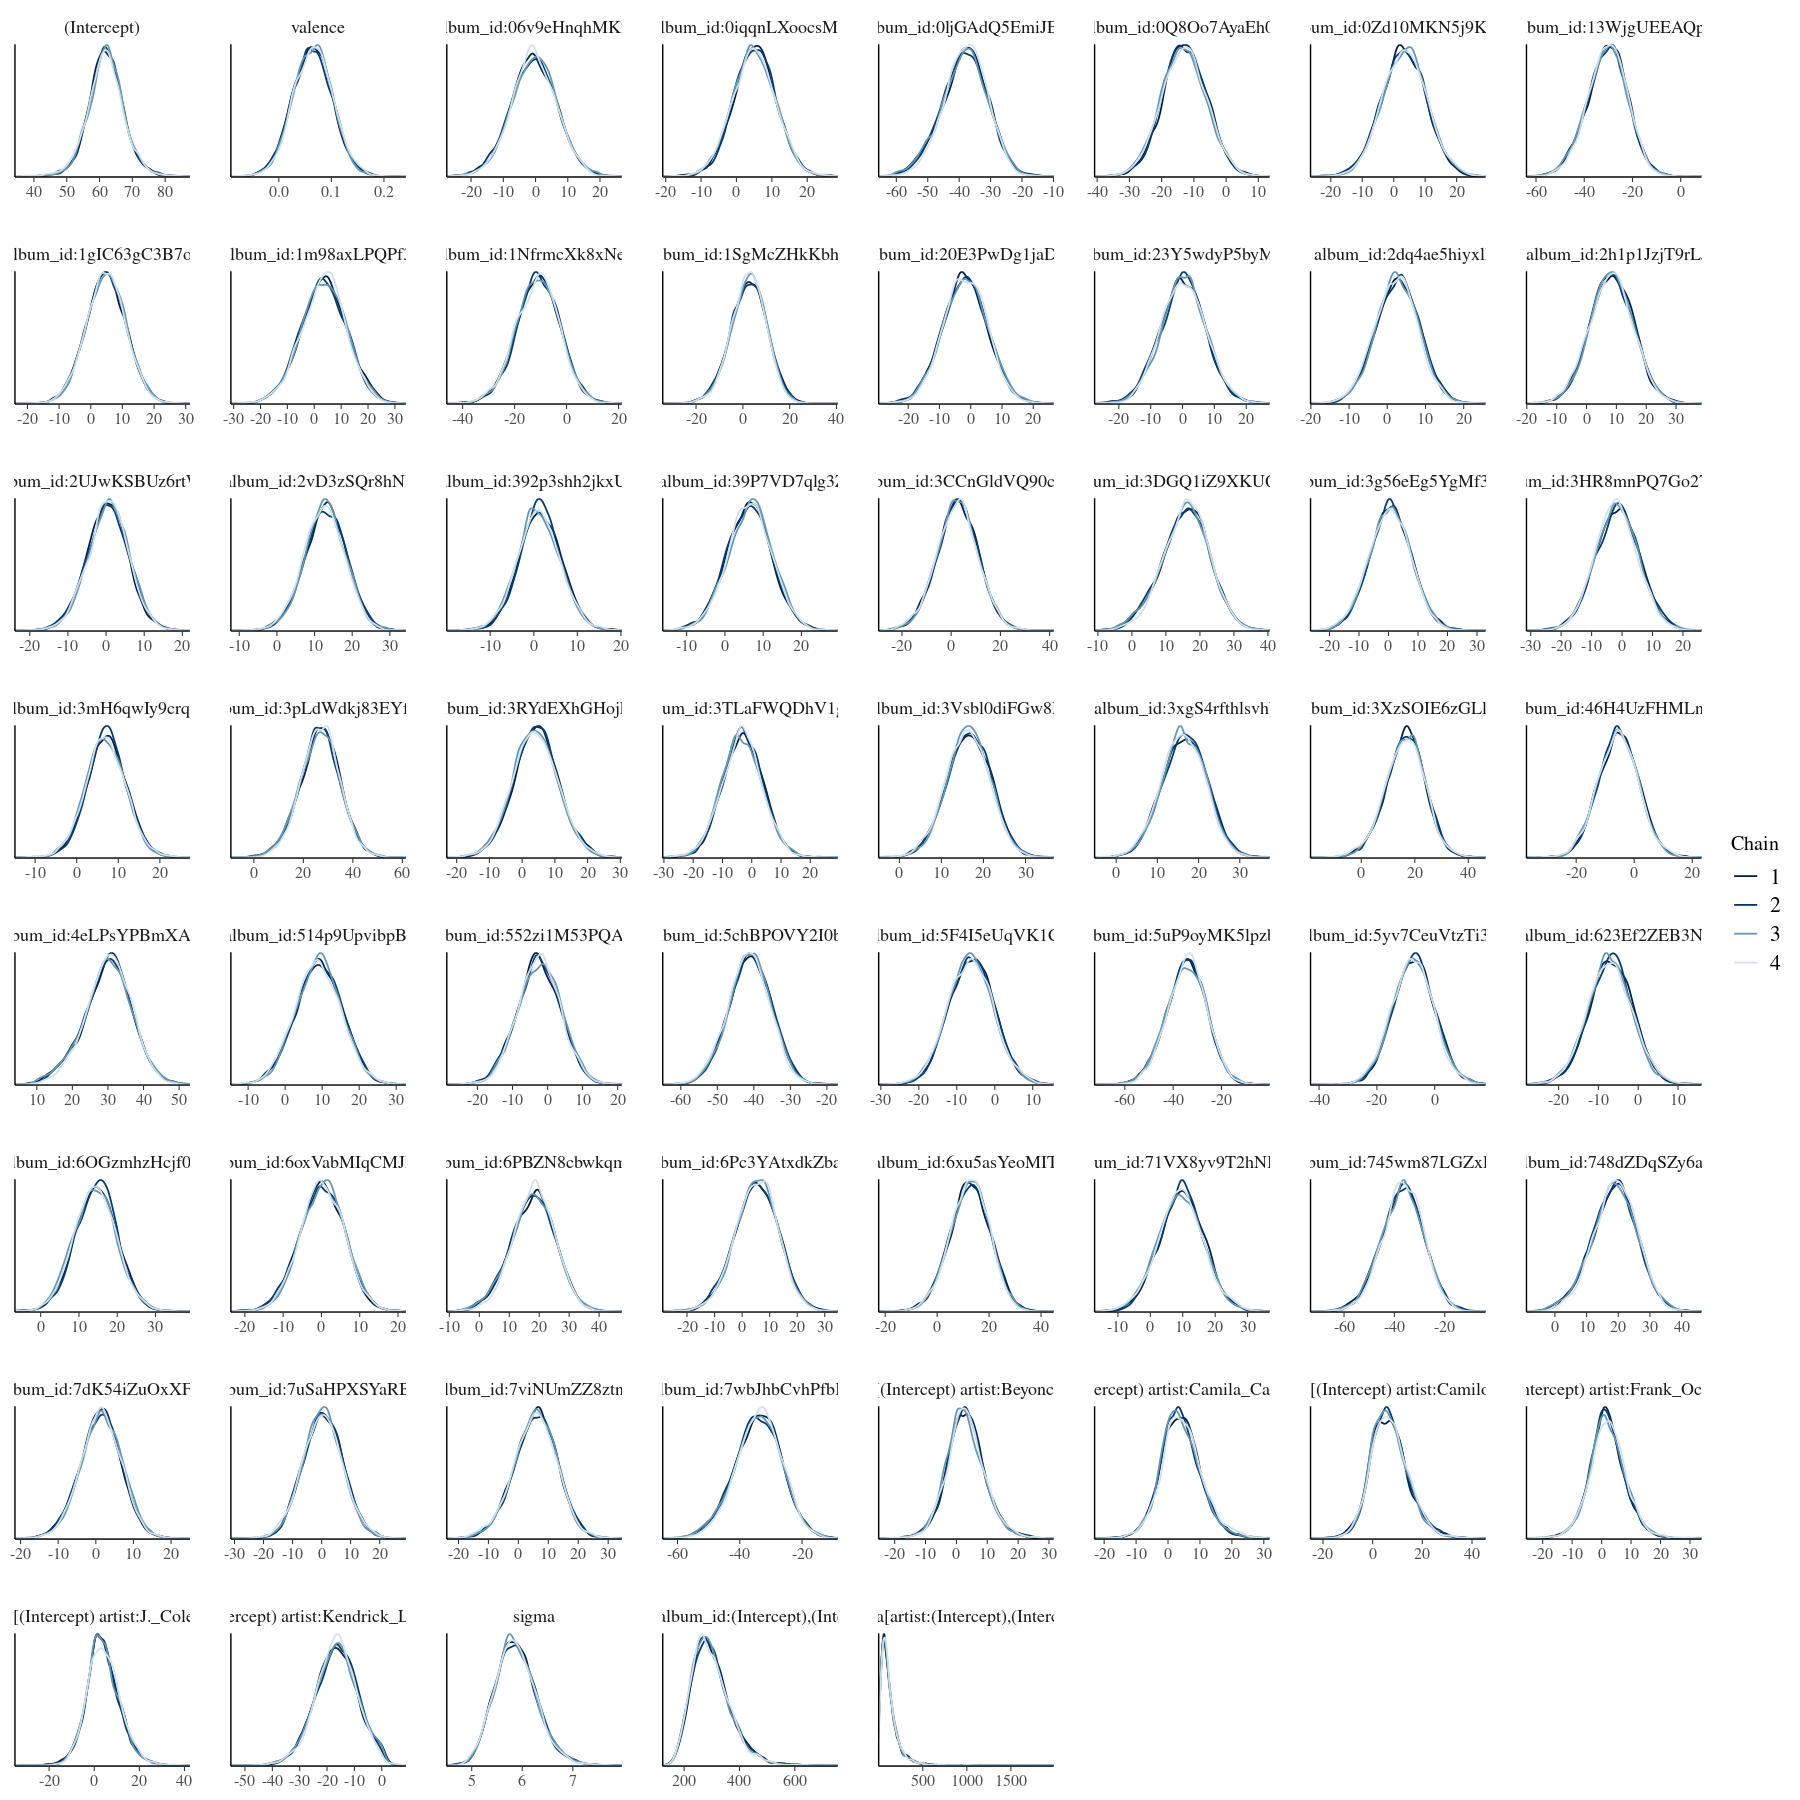

(Intercept) 
                                       0.35085 
                                       valence 
                                       0.75145 
b[(Intercept) album_id:06v9eHnqhMK2tbM2Iz3p0Y] 
                                       0.42360 
b[(Intercept) album_id:0iqqnLXoocsMeCYlTw3Q2q] 
                                       0.35480 
b[(Intercept) album_id:0ljGAdQ5EmiJE52O1VsYAM] 
                                       0.16525 
b[(Intercept) album_id:0Q8Oo7AyaEh0EzwSIOd1o0] 
                                       0.47320 
b[(Intercept) album_id:0Zd10MKN5j9KwUST0TdBBB] 
                                       0.37420 
b[(Intercept) album_id:13WjgUEEAQp0d9JqojlWp1] 
                                       0.22265 
b[(Intercept) album_id:1gIC63gC3B7o7FfpPACZQJ] 
                                       0.34080 
b[(Intercept) album_id:1m98axLPQPf3odJJQYc5ok] 
                                       0.39020 
b[(Intercept) album_id:1NfrmcXk8xNennyxQ57JcW] 
                                       0.43315 
b[(Intercept) album_id:1SgMcZHkKbhSIp820lMy8F] 
                                       0.30060 
b[(Intercept) album_id:20E3PwDg1jaDdK9K565luD] 
                                       0.43905 
b[(Intercept) album_id:23Y5wdyP5byMFktZf8AcWU] 
                                       0.42790 
b[(Intercept) album_id:2dq4ae5hiyxlFPG1s8rlq5] 
                                       0.28865 
b[(Intercept) album_id:2h1p1JzjT9rLJFAFrIkyrm] 
                                       0.41255 
b[(Intercept) album_id:2UJwKSBUz6rtW4QLK74kQu] 
                                       0.25930 
b[(Intercept) album_id:2vD3zSQr8hNlg0obNel4TE] 
                                       0.27315 
b[(Intercept) album_id:392p3shh2jkxUxY2VHvlH8] 
                                       0.25860 
b[(Intercept) album_id:39P7VD7qlg3Z0ltq60eHp7] 
                                       0.30340 
b[(Intercept) album_id:3CCnGldVQ90c26aFATC1PW] 
                                       0.44570 
b[(Intercept) album_id:3DGQ1iZ9XKUQxAUWjfC34w] 
                                       0.16085 
b[(Intercept) album_id:3g56eEg5YgMf3LZPHCMOx2] 
                                       0.43900 
b[(Intercept) album_id:3HR8mnPQ7Go27WPMTNR2um] 
                                       0.45035 
b[(Intercept) album_id:3mH6qwIy9crq0I9YQbOuDf] 
                                       0.25470 
b[(Intercept) album_id:3pLdWdkj83EYfDN6H2N8MR] 
                                       0.24260 
b[(Intercept) album_id:3RYdEXhGHojkTILUdtnRVJ] 
                                       0.46620 
b[(Intercept) album_id:3TLaFWQDhV1g39Qwd5sPAm] 
                                       0.43510 
b[(Intercept) album_id:3Vsbl0diFGw8HNSjG8ue9m] 
                                       0.25390 
b[(Intercept) album_id:3xgS4rfthlsvhW7J2WLiiR] 
                                       0.26980 
b[(Intercept) album_id:3XzSOIE6zGLliuqsVGLmUc] 
                                       0.34400 
b[(Intercept) album_id:46H4UzFHMLnGgpyrj9HpKr] 
                                       0.45940 
b[(Intercept) album_id:4eLPsYPBmXABThSJ821sqY] 
                                       0.14800 
b[(Intercept) album_id:514p9UpvibpBhShFgpZaxS] 
                                       0.34640 
b[(Intercept) album_id:552zi1M53PQAX5OH4FIdTx] 
                                       0.34120 
b[(Intercept) album_id:5chBPOVY2I0bG5V3igb5QL] 
                                       0.31540 
b[(Intercept) album_id:5F4I5eUqVK1CpQbzt1ntMC] 
                                       0.37330 
b[(Intercept) album_id:5uP9oyMK5lpzbB7K6UeT3X] 
                                       0.22065 
b[(Intercept) album_id:5yv7CeuVtzTi3SbOjCMOJH] 
                                       0.45650 
b[(Intercept) album_id:623Ef2ZEB3Njklix4PC0Rs] 
                                       0.32355 
b[(Intercept) album_id:6OGzmhzHcjf0uN9j7dYvZH] 
                                       0.31835 
b[(Intercept) album_id:6oxVabMIqCMJRYN1GqR3Vf] 
                                       0.30450 
b[(

(Intercept) 
                                      1.000352 
                                       valence 
                                      1.000298 
b[(Intercept) album_id:06v9eHnqhMK2tbM2Iz3p0Y] 
                                      1.000170 
b[(Intercept) album_id:0iqqnLXoocsMeCYlTw3Q2q] 
                                      1.000399 
b[(Intercept) album_id:0ljGAdQ5EmiJE52O1VsYAM] 
                                      1.002757 
b[(Intercept) album_id:0Q8Oo7AyaEh0EzwSIOd1o0] 
                                      1.000402 
b[(Intercept) album_id:0Zd10MKN5j9KwUST0TdBBB] 
                                      1.000438 
b[(Intercept) album_id:13WjgUEEAQp0d9JqojlWp1] 
                                      1.002005 
b[(Intercept) album_id:1gIC63gC3B7o7FfpPACZQJ] 
                                      1.000032 
b[(Intercept) album_id:1m98axLPQPf3odJJQYc5ok] 
                                      1.000361 
b[(Intercept) album_id:1NfrmcXk8xNennyxQ57JcW] 
                                      1.000239 
b[(Intercept) album_id:1SgMcZHkKbhSIp820lMy8F] 
                                      1.000382 
b[(Intercept) album_id:20E3PwDg1jaDdK9K565luD] 
                                      1.000076 
b[(Intercept) album_id:23Y5wdyP5byMFktZf8AcWU] 
                                      1.000201 
b[(Intercept) album_id:2dq4ae5hiyxlFPG1s8rlq5] 
                                      1.001272 
b[(Intercept) album_id:2h1p1JzjT9rLJFAFrIkyrm] 
                                      1.000352 
b[(Intercept) album_id:2UJwKSBUz6rtW4QLK74kQu] 
                                      1.000394 
b[(Intercept) album_id:2vD3zSQr8hNlg0obNel4TE] 
                                      1.001298 
b[(Intercept) album_id:392p3shh2jkxUxY2VHvlH8] 
                                      1.001005 
b[(Intercept) album_id:39P7VD7qlg3Z0ltq60eHp7] 
                                      1.000475 
b[(Intercept) album_id:3CCnGldVQ90c26aFATC1PW] 
                                      1.000061 
b[(Intercept) album_id:3DGQ1iZ9XKUQxAUWjfC34w] 
                                      1.002491 
b[(Intercept) album_id:3g56eEg5YgMf3LZPHCMOx2] 
                                      1.000550 
b[(Intercept) album_id:3HR8mnPQ7Go27WPMTNR2um] 
                                      1.000828 
b[(Intercept) album_id:3mH6qwIy9crq0I9YQbOuDf] 
                                      1.000791 
b[(Intercept) album_id:3pLdWdkj83EYfDN6H2N8MR] 
                                      1.001524 
b[(Intercept) album_id:3RYdEXhGHojkTILUdtnRVJ] 
                                      1.000587 
b[(Intercept) album_id:3TLaFWQDhV1g39Qwd5sPAm] 
                                      1.000361 
b[(Intercept) album_id:3Vsbl0diFGw8HNSjG8ue9m] 
                                      1.001277 
b[(Intercept) album_id:3xgS4rfthlsvhW7J2WLiiR] 
                                      1.001602 
b[(Intercept) album_id:3XzSOIE6zGLliuqsVGLmUc] 
                                      1.000449 
b[(Intercept) album_id:46H4UzFHMLnGgpyrj9HpKr] 
                                      1.000157 
b[(Intercept) album_id:4eLPsYPBmXABThSJ821sqY] 
                                      1.002787 
b[(Intercept) album_id:514p9UpvibpBhShFgpZaxS] 
                                      1.000957 
b[(Intercept) album_id:552zi1M53PQAX5OH4FIdTx] 
                                      1.000321 
b[(Intercept) album_id:5chBPOVY2I0bG5V3igb5QL] 
                                      1.001464 
b[(Intercept) album_id:5F4I5eUqVK1CpQbzt1ntMC] 
                                      1.000708 
b[(Intercept) album_id:5uP9oyMK5lpzbB7K6UeT3X] 
                                      1.001833 
b[(Intercept) album_id:5yv7CeuVtzTi3SbOjCMOJH] 
                                      1.000899 
b[(Intercept) album_id:623Ef2ZEB3Njklix4PC0Rs] 
                                      1.000701 
b[(Intercept) album_id:6OGzmhzHcjf0uN9j7dYvZH] 
                                      1.000781 
b[(Intercept) album_id:6oxVabMIqCMJRYN1GqR3Vf] 
                                      1.000351 
b[(

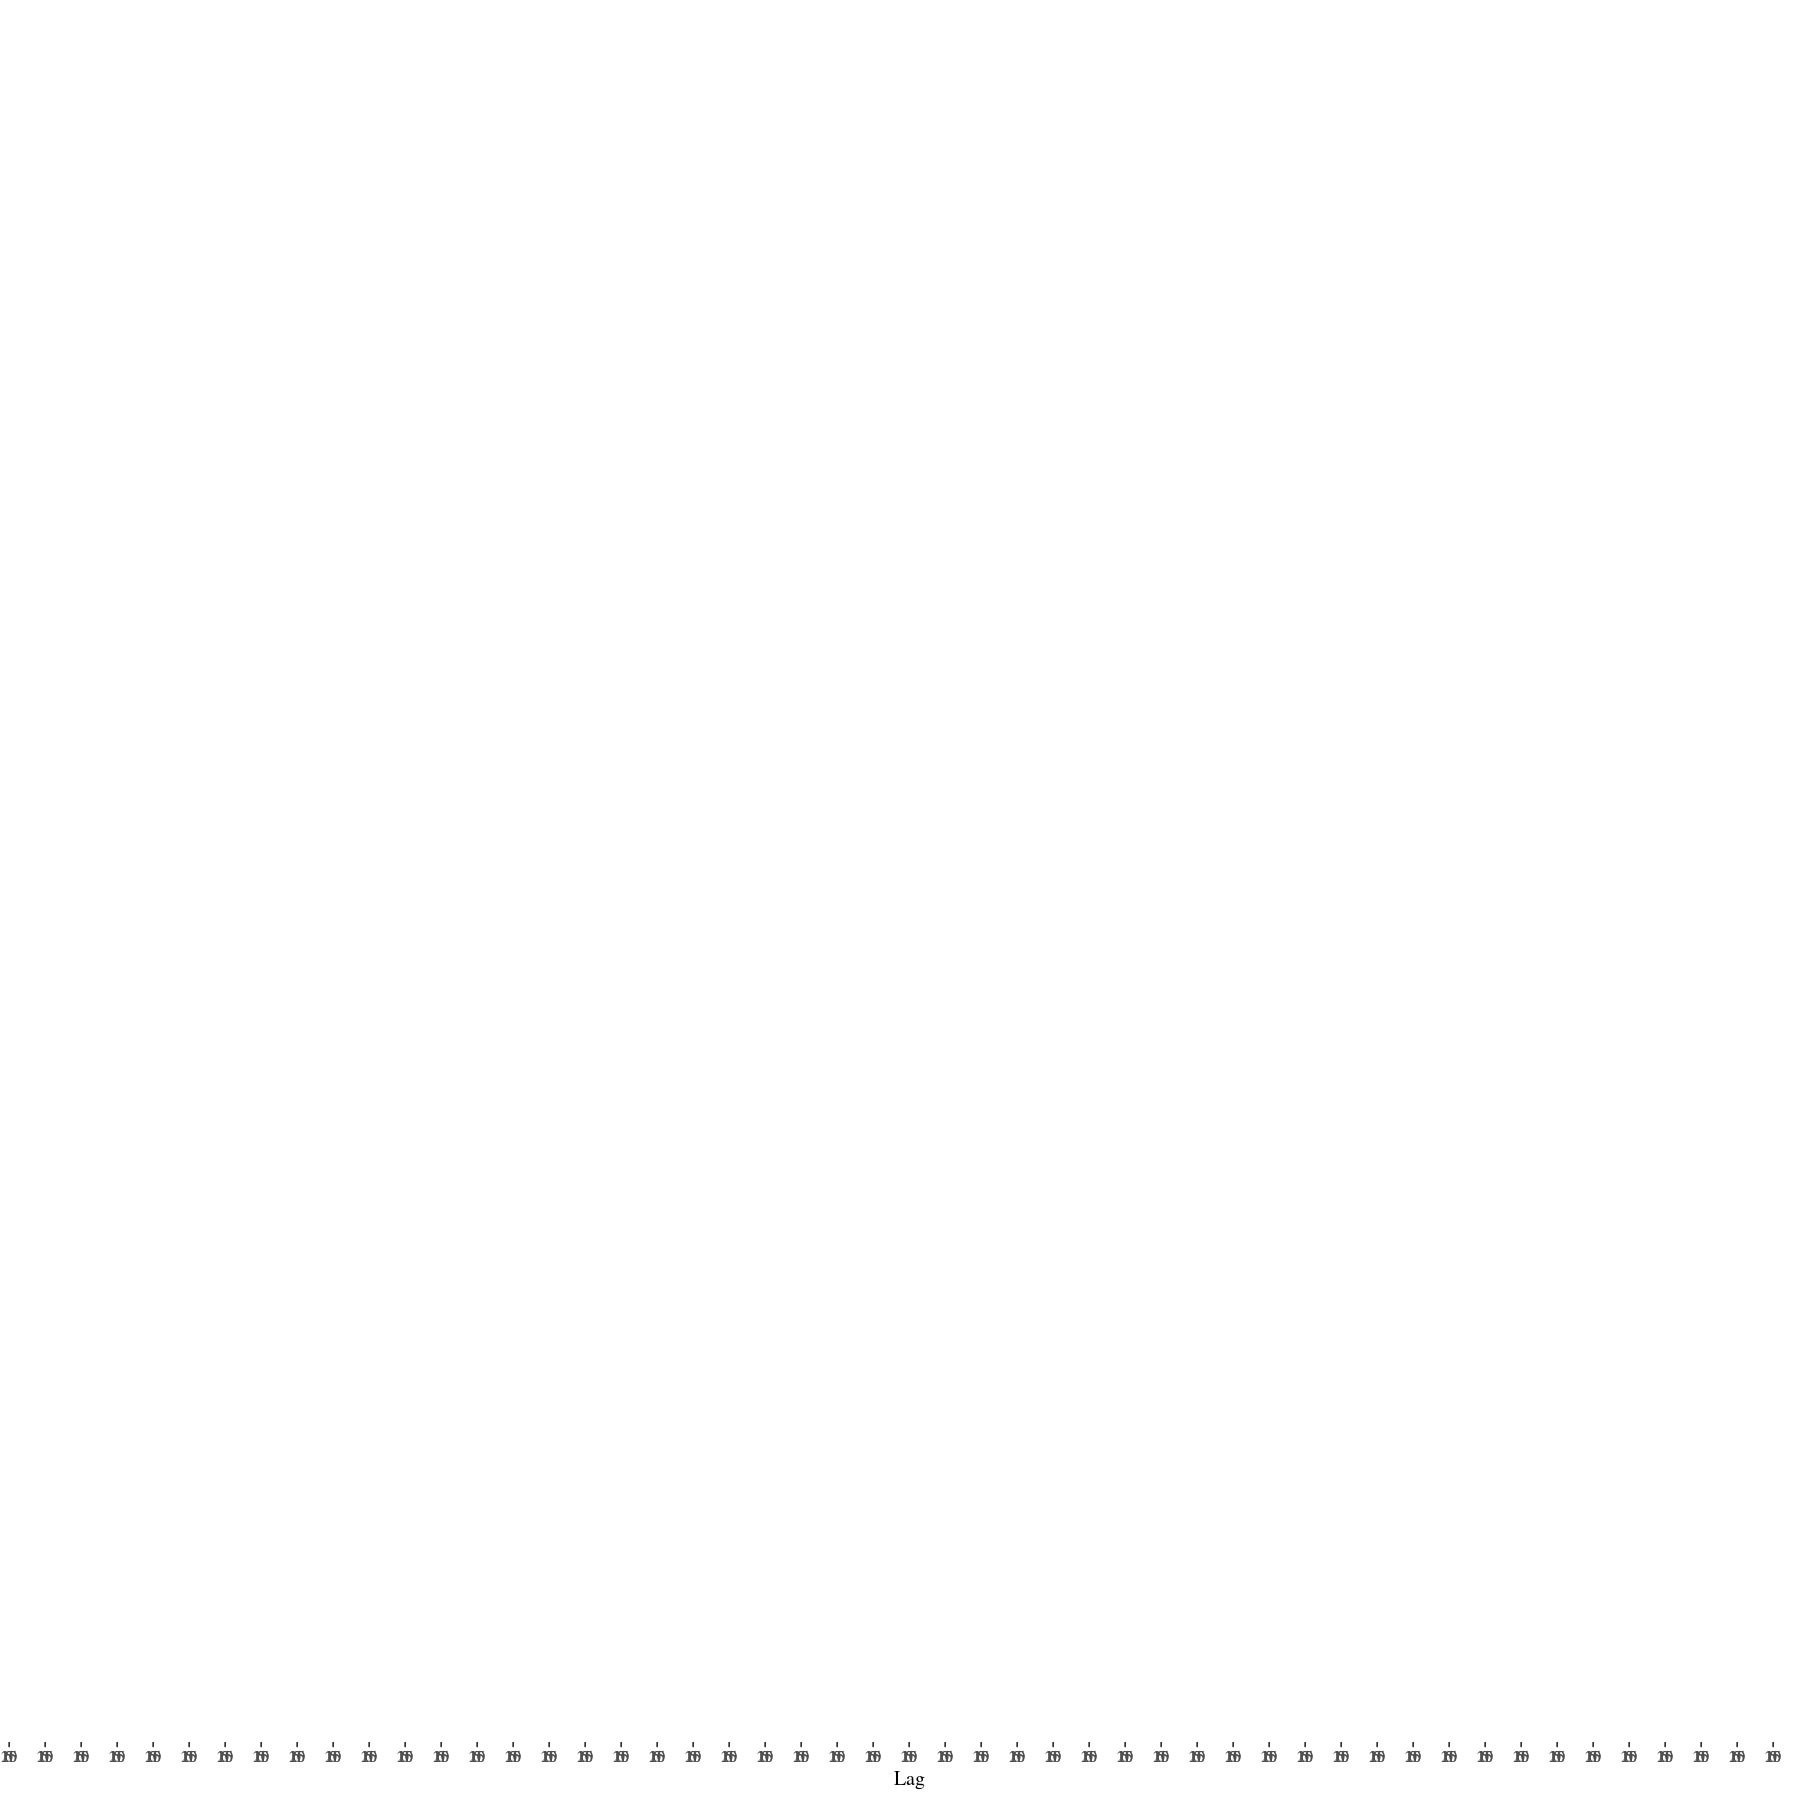

In [20]:
options(repr.plot.width=15, repr.plot.height=15)
mcmc_trace(spotify_model_2, size = 0.1)
mcmc_dens_overlay(spotify_model_2)
mcmc_acf(spotify_model_2)
neff_ratio(spotify_model_2)
rhat(spotify_model_2)

Looks ok, ignore the warning, however in practice one should tweak the MCMC parameters here.

Posterior predictive check:

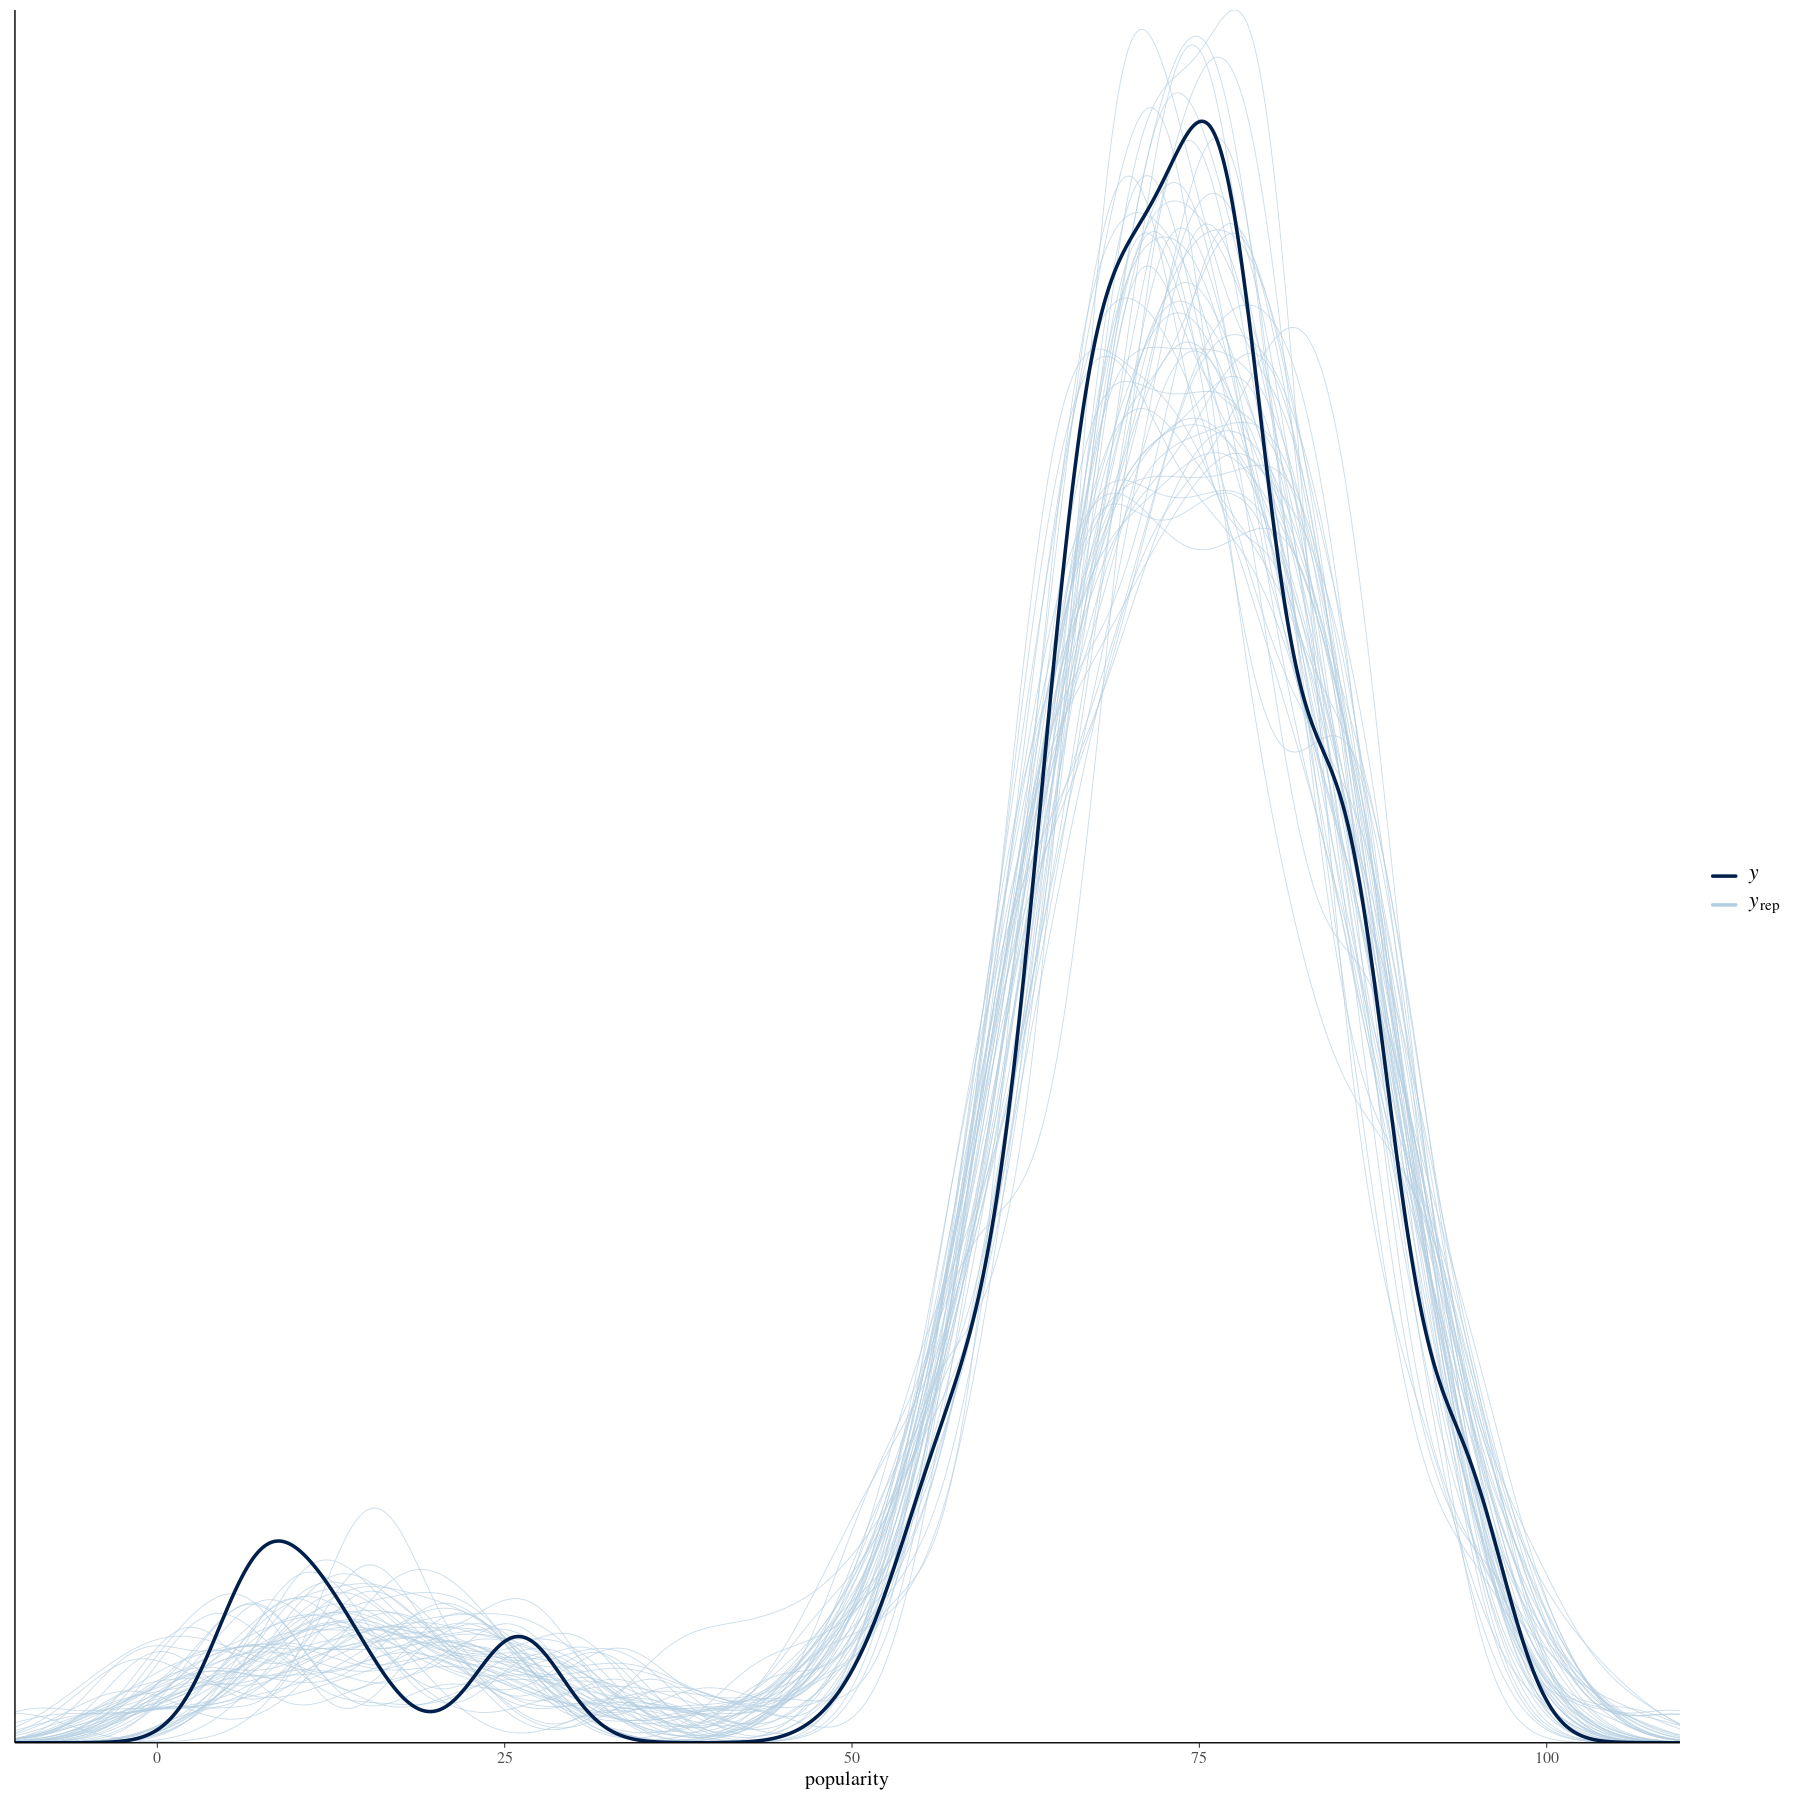

In [21]:
pp_check(spotify_model_2) + xlab("popularity")

Wow, this is much better!

## Exercise 19.7

### a)

Fixed effects:

In [22]:
tidy(spotify_model_2, effects = "fixed")

term        estimate    std.error 
1 (Intercept) 61.95850503 5.01287305
2 valence      0.06480214 0.03787398

Random effects:

In [23]:
tidy(spotify_model_2, effects = "ran_vals") %>% 
    filter( level %in% c("Kendrick_Lamar", "748dZDqSZy6aPXKcI9H80u") )

level                  group    term        estimate  std.error
1 748dZDqSZy6aPXKcI9H80u album_id (Intercept)  19.02559 7.044108 
2 Kendrick_Lamar         artist   (Intercept) -16.42305 7.635712

* Albums by artists not included in the `spotify_small` dataset: popularity = 62.0 + 0.065 * valence
* A new album by Kendrick Lamar: popularity = 62.0 - 16.4 + 0.065 * valence = 45.5 + 0.065 * valence
* Kendrick Lamar’s “good kid, m.A.A.d city” album: 62.0 - 16.4 + 19.0 + 0.065 * valence = 64.6 + 0.065 * valence

### b)

Kendrick Lamar has in general a worse average popularity than the average of our sample. However his Album “good kid, m.A.A.d city” was so popular that a song in it has a larger popularity than the average of our sample.

### c)

In [24]:
tidy(spotify_model_2, effects = "ran_vals") %>% 
    filter( group == "artist" ) %>% 
    arrange( desc(estimate) )

level          group  term        estimate   std.error
1 Camilo         artist (Intercept)   6.298670 7.279473 
2 Camila_Cabello artist (Intercept)   3.748713 5.899080 
3 J._Cole        artist (Intercept)   3.601396 6.845808 
4 Beyoncé        artist (Intercept)   2.820226 5.765683 
5 Frank_Ocean    artist (Intercept)   1.791417 5.608984 
6 Kendrick_Lamar artist (Intercept) -16.423055 7.635712

Camilo.

### d)

Most popular album:

In [25]:
tidy(spotify_model_2, effects = "ran_vals") %>% 
    filter( group == "album_id" ) %>% 
    arrange( desc(estimate) ) %>% 
    head()

level                  group    term        estimate std.error
1 4eLPsYPBmXABThSJ821sqY album_id (Intercept) 30.25010 6.429640 
2 3pLdWdkj83EYfDN6H2N8MR album_id (Intercept) 26.84868 7.875206 
3 748dZDqSZy6aPXKcI9H80u album_id (Intercept) 19.02559 7.044108 
4 6PBZN8cbwkqm1ERj2BGXJ1 album_id (Intercept) 18.18493 7.323289 
5 3XzSOIE6zGLliuqsVGLmUc album_id (Intercept) 16.67567 7.243112 
6 3Vsbl0diFGw8HNSjG8ue9m album_id (Intercept) 16.50975 5.246488

In [26]:
spotify %>%
    filter( album_id == "4eLPsYPBmXABThSJ821sqY" ) %>% 
    select( artist, album_name ) %>% 
    first()

artist         album_name
1 Kendrick Lamar DAMN.

## Exercise 19.8

In [27]:
tidy(spotify_model_2, effects = "ran_pars") %>% 
    mutate( squared = estimate^2 ) %>% 
    mutate( proportion = squared/sum(squared) ) %>% 
    select( -squared )

term                    group    estimate  proportion
1 sd_(Intercept).album_id album_id 17.299246 0.65699327
2 sd_(Intercept).artist   artist   11.029960 0.26708805
3 sd_Observation.Residual Residual  5.880592 0.07591869

$\sigma_y = 5.9, \sigma_b = 17.3, \sigma_p = 11.0$ ($\sigma_b$ represents variability between different albums of an artist and $\sigma_p$ variability between artists).

The largest proportion of variability in popularity (65%) comes from $\sigma_b$, i.e. the albums of an artist, followed by $\sigma_p$, the variability of popularity between artists. The variability of the popularity of songs within an album is interestingly the smallest. It appears thus that most artists do not consistently produce good albums, but rather a diverse range of popular and unpopular albums. The variance in the individual songs of an album is rather small (7.6%) compared with the other effects, i.e. if one song in an album is popular, usually the rest is also popular and the other way round.

## Exercise 19.9

In [28]:
bwc <- big_word_club %>% 
      mutate(treat = as.factor(treat))

### a)

* school-level predictors: treat, private_school, free_reduced_lunch
* student-level predictors: age_months, esl_observed (English as a second language)

Interestingly, `treat` is a school-level predictor and the same for all students at a particular school.

In [29]:
bwc %>% 
    group_by( school_id ) %>% 
    summarize( 
        var_private_school = var(private_school),
        var_lunch = var(free_reduced_lunch),
        var_treat = var(as.numeric(treat)-1),
        var_age_months = var(age_months),
        var_esl_observed = var(esl_observed)
    ) %>% 
    mutate_if( is.factor, \(x) as.numeric(x)-1 ) %>% 
    summarize_all( max ) %>% 
    select(-school_id)

var_private_school var_lunch var_treat var_age_months var_esl_observed
1 0                  0         0         174.8603       0.2614379

No variance among the school-level predictors, variance among the student-level predictors.

### b)

How many tests per student?

In [30]:
bwc %>% 
    count( participant_id ) %>% 
    filter( n>1 )

participant_id n

Only one! Not a nested grouping structure.

Use a normal hierarchical regression model with random intercepts. For simplicity, do not use random slopes.

$$Y_{ij} | \beta_{0}, b_{0j}, \beta_1, \sigma_y \sim N(\mu_{ij}, \sigma_y^2), \quad \text{with } \mu_{ij} = \left(\beta_{0} + b_{0j}\right) + \beta_1 U_{j1} + \beta_2 U_{j2} + \beta_3 U_{j3} \beta_3 X_{ijk3} + \beta_4 X_{ij4} + \beta_5 X_{k5}$$ 

$$b_{0j}|\sigma_b \sim N(0, \sigma_b^2)$$

$$\beta_{0c}, \beta_{1}, \beta_{2}, \beta_{3}, \beta_{4}, \beta_{5}\sim N(0, s_0^2)$$

$$\sigma_b \sim \text{Exp}(l_b)$$

$$\sigma_y \sim \text{Exp}(l_y)$$

Here, $Y_{ij}$ stands for percent change in score for student $i$ at school $j$. $b_{0j}$ represents the different baseline percent changes for the different schools and $\sigma_y$ the variability within the different students at an individual school. $\beta_1$, $\beta_2$ and $\beta_3$ are the global slope parameters for the school-level predictors `treat`, `private_school` and `free_reduced_lunch` (denoted as $U_{j1}$, $U_{j2}$ and $U_{j3}$). $\beta_4$ and $\beta_5$ are the slopes for the student-level predictors  `age_months` and `esl_observed` (denoted as $X_{ij1}$ and $X_{ij2}$).

### c)

In [31]:
bwc_model <- stan_glmer(
  score_pct_change ~ age_months + esl_observed + treat + private_school + 
                     free_reduced_lunch + (1 | school_id), 
  data = bwc, family = gaussian,
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735,
)

Diagnostics:

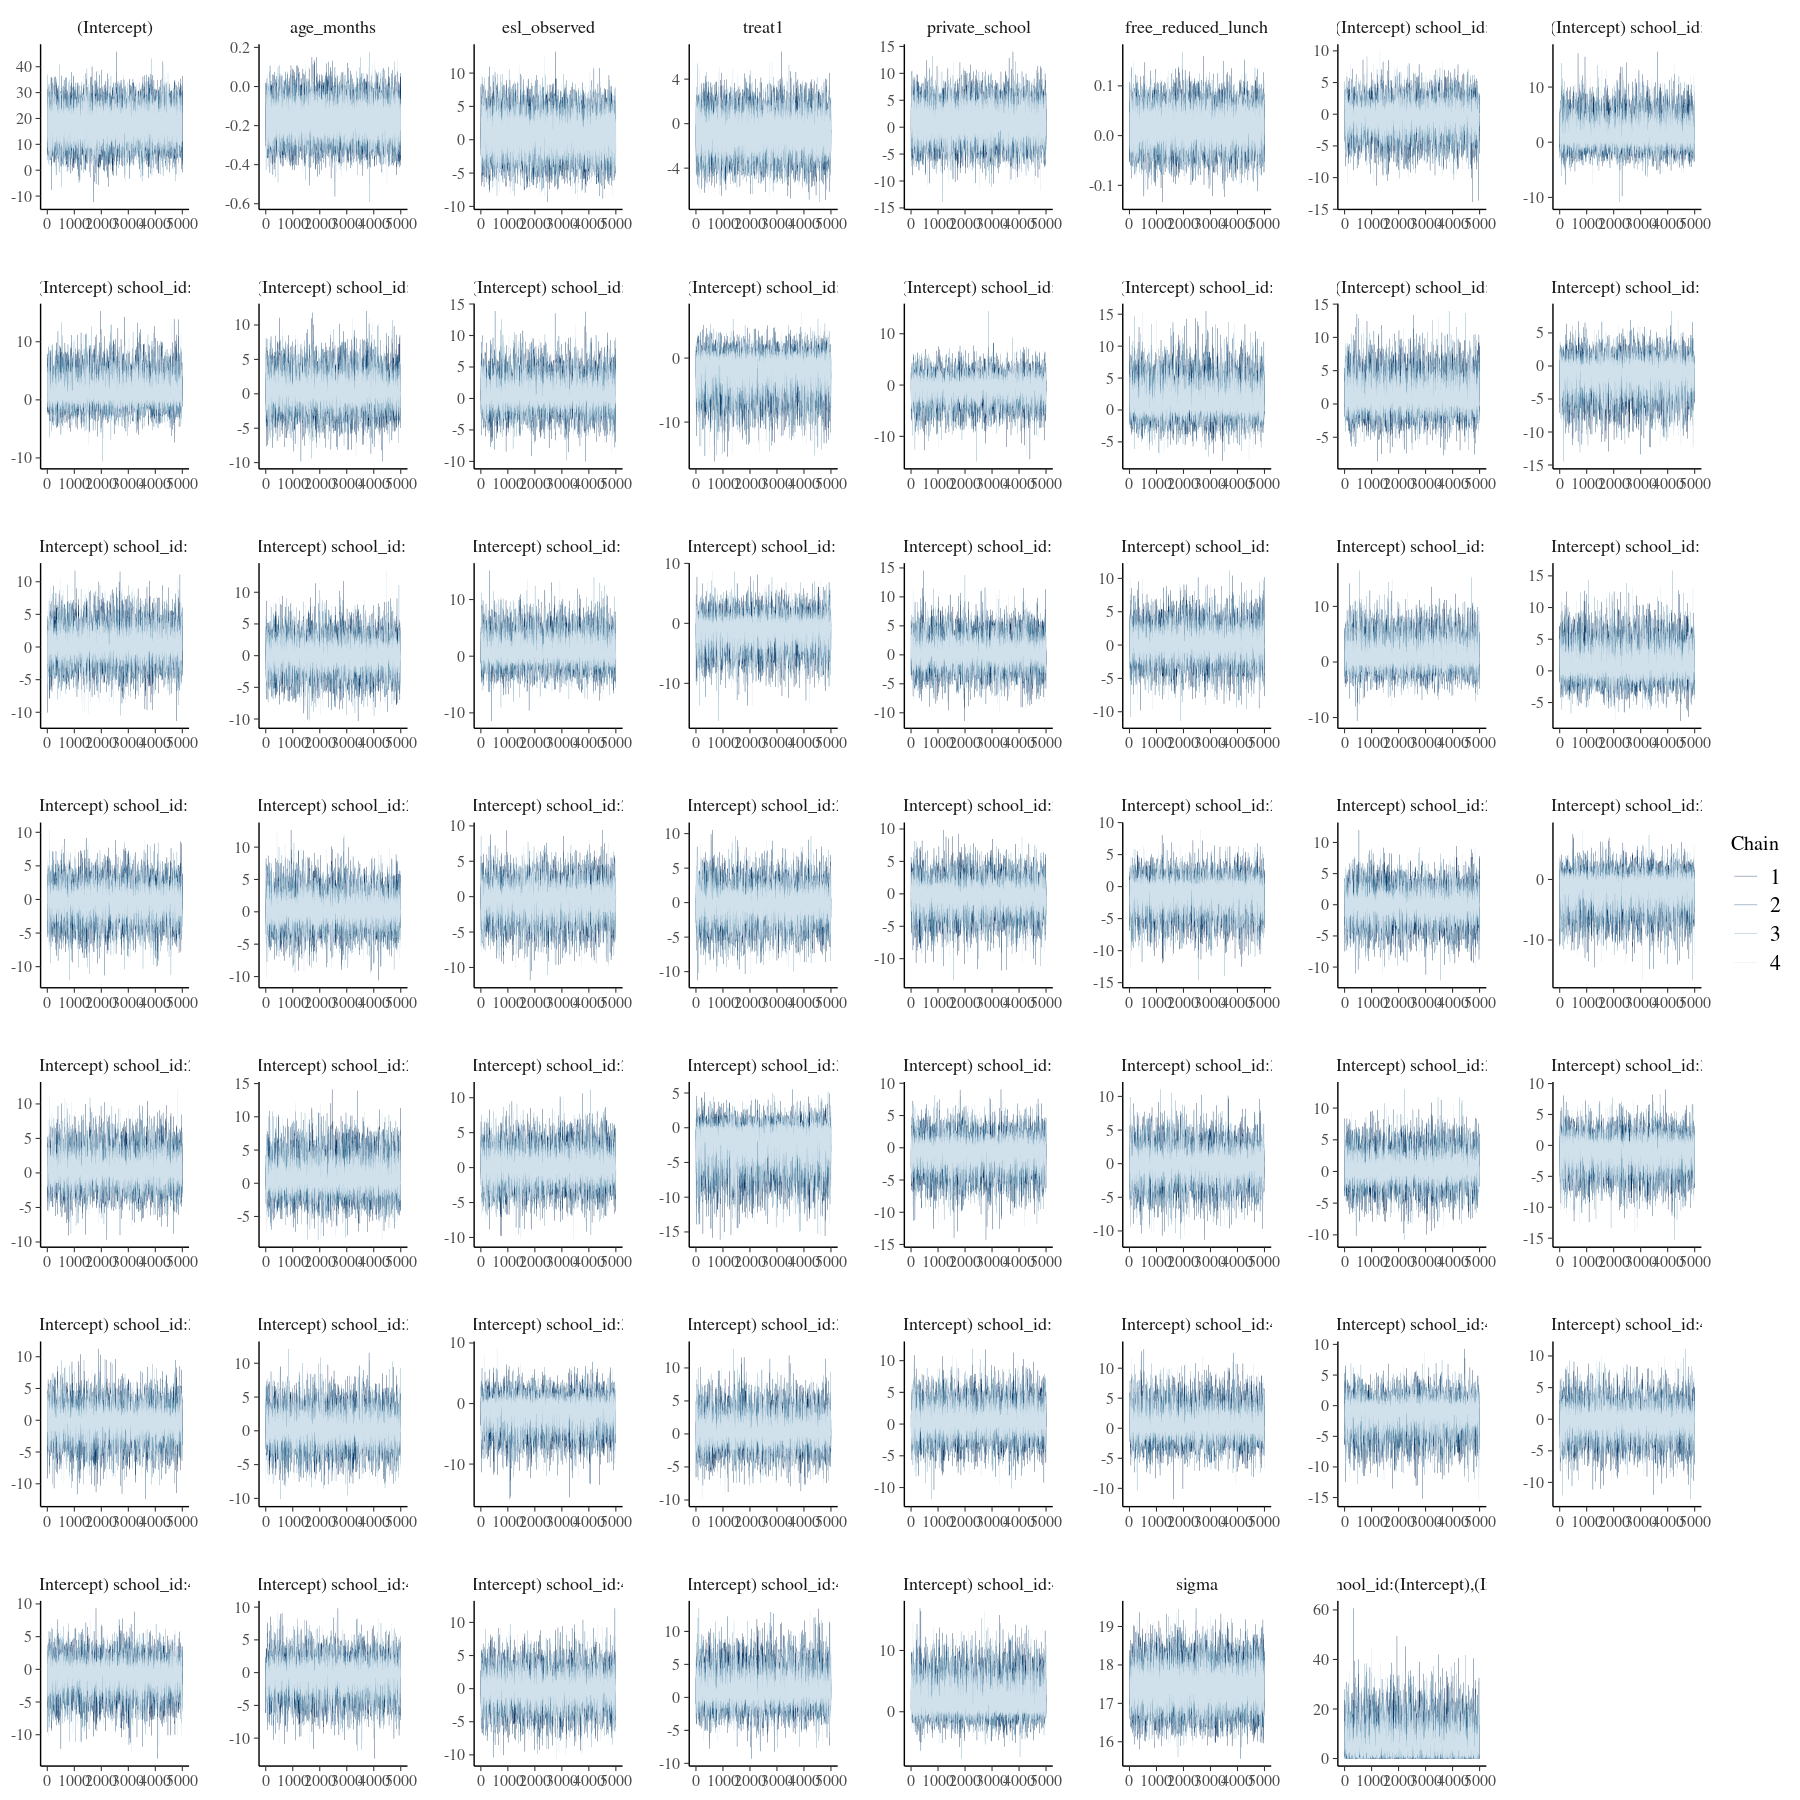

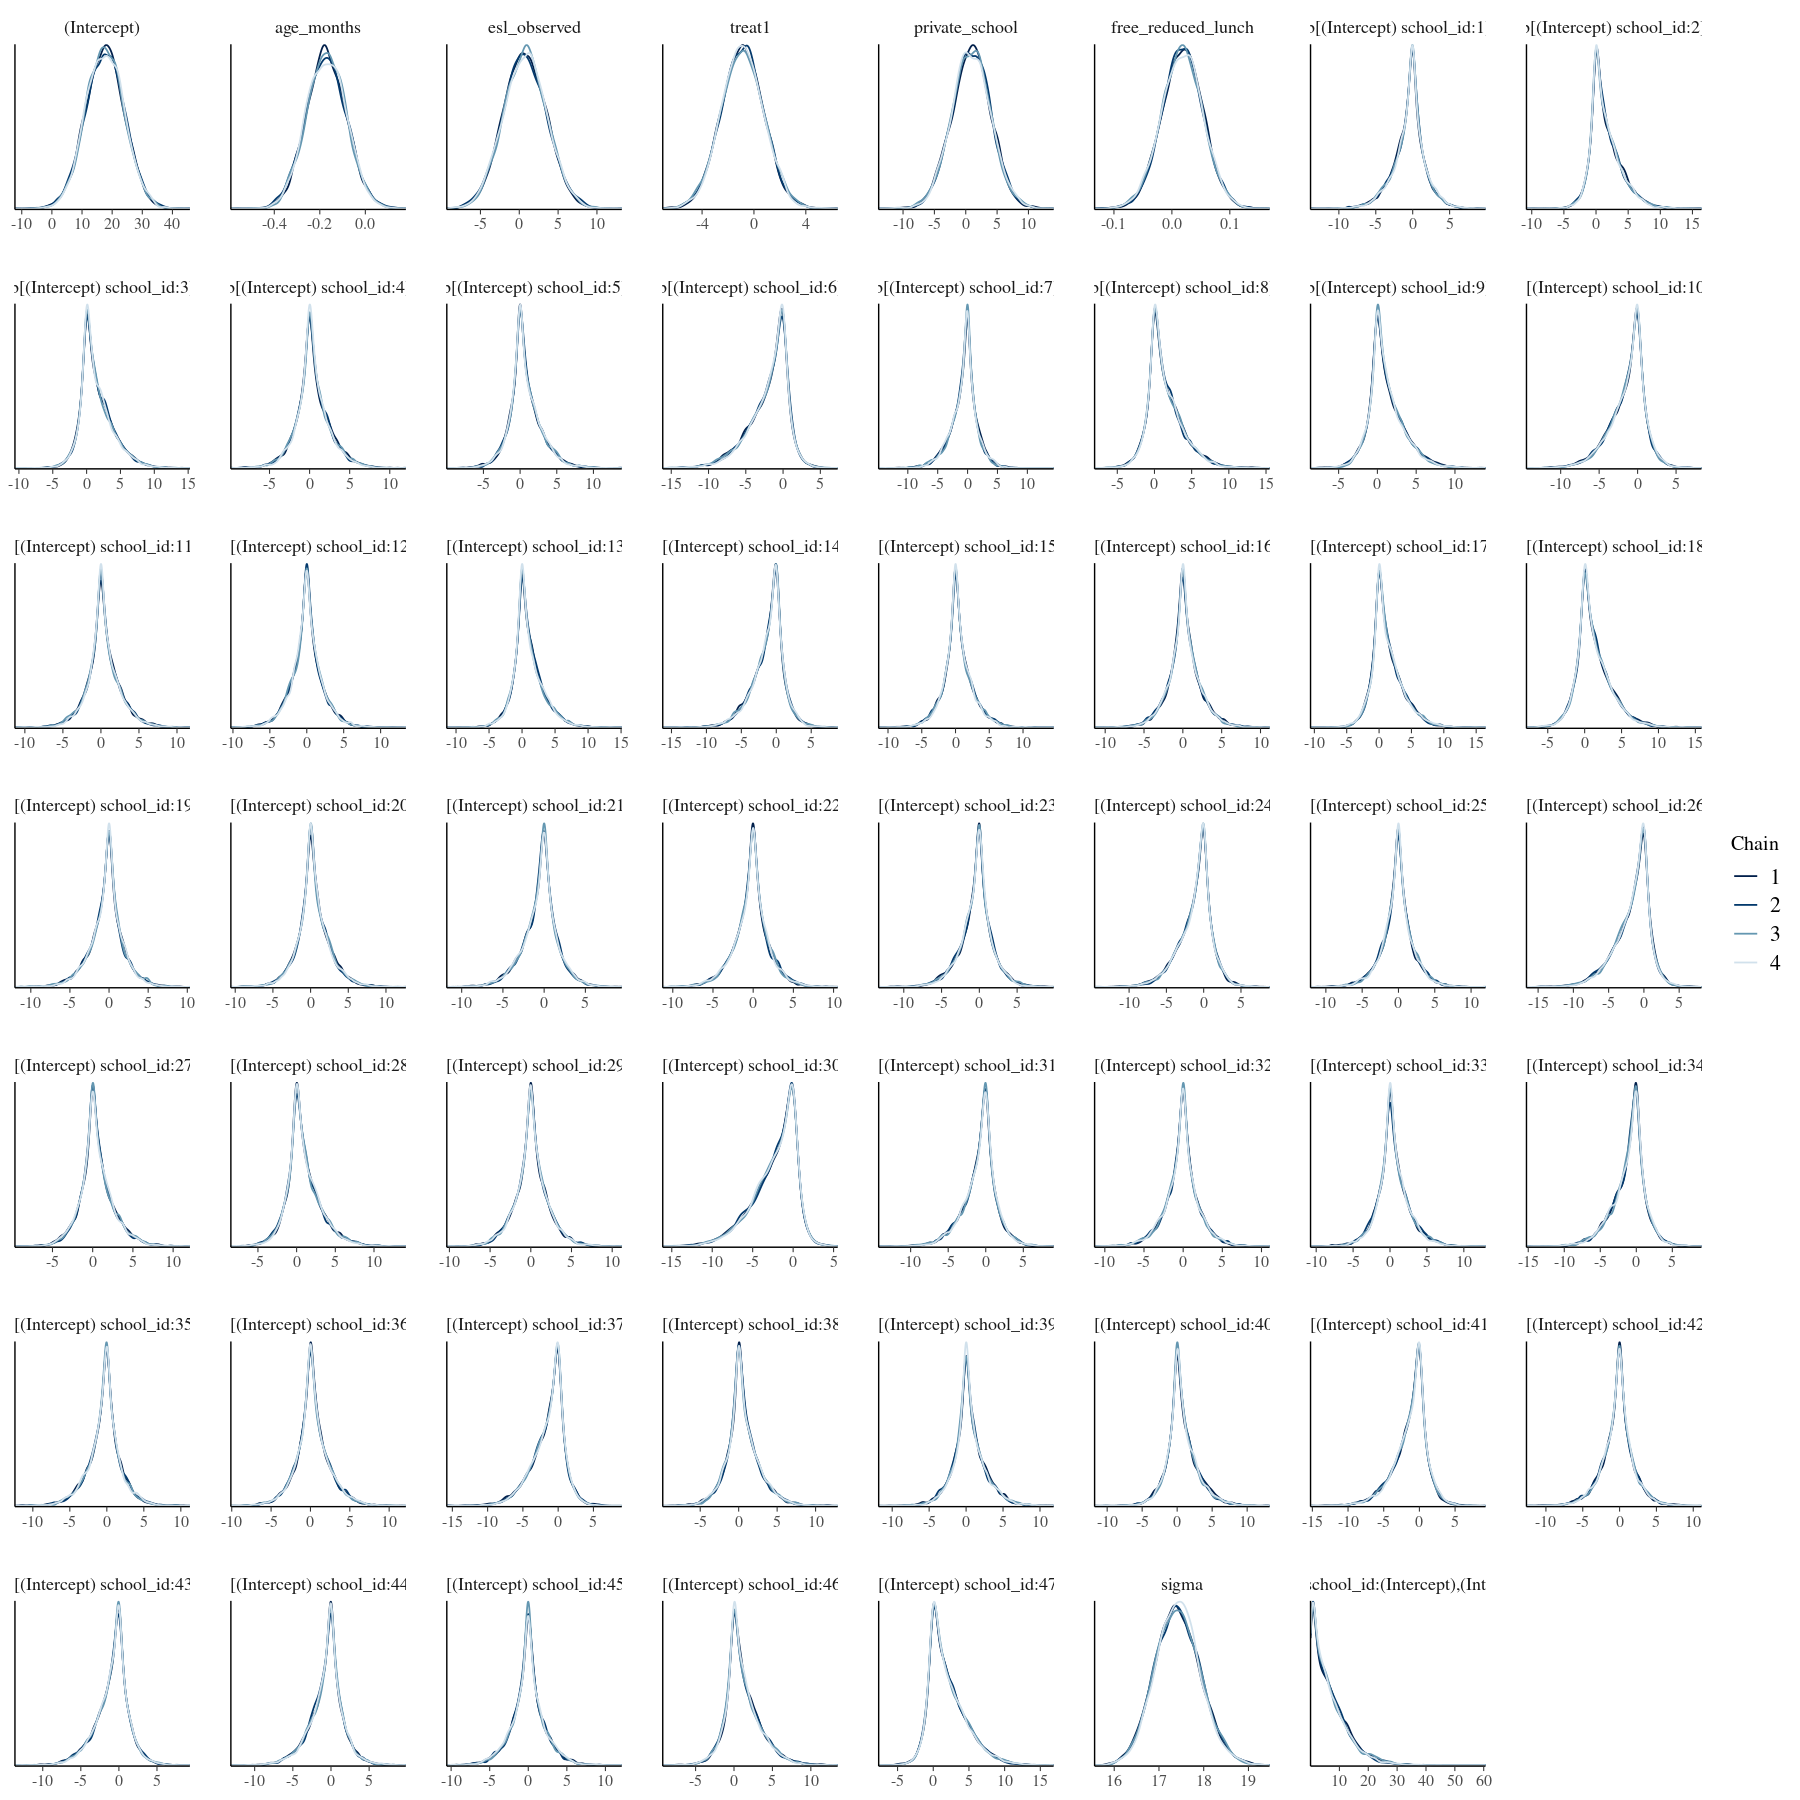

(Intercept) 
                                 1.46045 
                              age_months 
                                 1.51280 
                            esl_observed 
                                 1.35055 
                                  treat1 
                                 1.38495 
                          private_school 
                                 1.05085 
                      free_reduced_lunch 
                                 0.98395 
              b[(Intercept) school_id:1] 
                                 1.44375 
              b[(Intercept) school_id:2] 
                                 0.76115 
              b[(Intercept) school_id:3] 
                                 0.78305 
              b[(Intercept) school_id:4] 
                                 1.45975 
              b[(Intercept) school_id:5] 
                                 1.21750 
              b[(Intercept) school_id:6] 
                                 0.62650 
              b[(Intercept) school_id:7] 
                                 1.34610 
              b[(Intercept) school_id:8] 
                                 0.84195 
              b[(Intercept) school_id:9] 
                                 0.96700 
             b[(Intercept) school_id:10] 
                                 0.83920 
             b[(Intercept) school_id:11] 
                                 1.42510 
             b[(Intercept) school_id:12] 
                                 1.67155 
             b[(Intercept) school_id:13] 
                                 1.14840 
             b[(Intercept) school_id:14] 
                                 0.89240 
             b[(Intercept) school_id:15] 
                                 1.53410 
             b[(Intercept) school_id:16] 
                                 1.56020 
             b[(Intercept) school_id:17] 
                                 0.88855 
             b[(Intercept) school_id:18] 
                                 0.95585 
             b[(Intercept) school_id:19] 
                                 1.47340 
             b[(Intercept) school_id:20] 
                                 1.48615 
             b[(Intercept) school_id:21] 
                                 1.49395 
             b[(Intercept) school_id:22] 
                                 1.50860 
             b[(Intercept) school_id:23] 
                                 1.43985 
             b[(Intercept) school_id:24] 
                                 0.99185 
             b[(Intercept) school_id:25] 
                                 1.61610 
             b[(Intercept) school_id:26] 
                                 0.79345 
             b[(Intercept) school_id:27] 
                                 1.35000 
             b[(Intercept) school_id:28] 
                                 1.20875 
             b[(Intercept) school_id:29] 
                                 1.53340 
             b[(Intercept) school_id:30] 
                                 0.55240 
             b[(Intercept) school_id:31] 
                                 1.26505 
             b[(Intercept) school_id:32] 
                                 1.58735 
             b[(Intercept) school_id:33] 
                                 1.53995 
             b[(Intercept) school_id:34] 
                                 0.97420 
             b[(Intercept) school_id:35] 
                                 1.20365 
             b[(Intercept) school_id:36] 
                                 1.55360 
             b[(Intercept) school_id:37] 
                                 0.85045 
             b[(Intercept) school_id:38] 
                                 1.36305 
             b[(Intercept) school_id:39] 
                                 1.50755 
             b[(Intercept) school_id:40] 
                                 1.30075 
             b[(Intercept) school_id:41] 
                                 0.87355 
             b[(Intercept) school_id:42] 
                                 1.4430

(Intercept) 
                               0.9999639 
                              age_months 
                               0.9999107 
                            esl_observed 
                               1.0000186 
                                  treat1 
                               0.9998584 
                          private_school 
                               0.9999473 
                      free_reduced_lunch 
                               1.0000956 
              b[(Intercept) school_id:1] 
                               1.0000306 
              b[(Intercept) school_id:2] 
                               1.0001294 
              b[(Intercept) school_id:3] 
                               1.0000966 
              b[(Intercept) school_id:4] 
                               0.9998791 
              b[(Intercept) school_id:5] 
                               1.0000320 
              b[(Intercept) school_id:6] 
                               1.0001433 
              b[(Intercept) school_id:7] 
                               0.9998945 
              b[(Intercept) school_id:8] 
                               0.9999242 
              b[(Intercept) school_id:9] 
                               0.9999746 
             b[(Intercept) school_id:10] 
                               1.0000504 
             b[(Intercept) school_id:11] 
                               0.9999222 
             b[(Intercept) school_id:12] 
                               0.9998364 
             b[(Intercept) school_id:13] 
                               0.9998688 
             b[(Intercept) school_id:14] 
                               0.9999437 
             b[(Intercept) school_id:15] 
                               0.9999300 
             b[(Intercept) school_id:16] 
                               0.9999058 
             b[(Intercept) school_id:17] 
                               1.0002009 
             b[(Intercept) school_id:18] 
                               1.0001016 
             b[(Intercept) school_id:19] 
                               0.9999552 
             b[(Intercept) school_id:20] 
                               0.9999521 
             b[(Intercept) school_id:21] 
                               0.9998749 
             b[(Intercept) school_id:22] 
                               0.9998664 
             b[(Intercept) school_id:23] 
                               1.0000508 
             b[(Intercept) school_id:24] 
                               1.0000837 
             b[(Intercept) school_id:25] 
                               0.9999964 
             b[(Intercept) school_id:26] 
                               1.0000112 
             b[(Intercept) school_id:27] 
                               0.9999932 
             b[(Intercept) school_id:28] 
                               0.9999397 
             b[(Intercept) school_id:29] 
                               0.9999158 
             b[(Intercept) school_id:30] 
                               1.0000399 
             b[(Intercept) school_id:31] 
                               0.9999791 
             b[(Intercept) school_id:32] 
                               0.9998985 
             b[(Intercept) school_id:33] 
                               0.9998890 
             b[(Intercept) school_id:34] 
                               0.9999144 
             b[(Intercept) school_id:35] 
                               0.9998752 
             b[(Intercept) school_id:36] 
                               0.9999603 
             b[(Intercept) school_id:37] 
                               0.9999318 
             b[(Intercept) school_id:38] 
                               0.9999687 
             b[(Intercept) school_id:39] 
                               1.0000024 
             b[(Intercept) school_id:40] 
                               1.0001443 
             b[(Intercept) school_id:41] 
                               1.0001333 
             b[(Intercept) school_id:42] 
                               0.999915

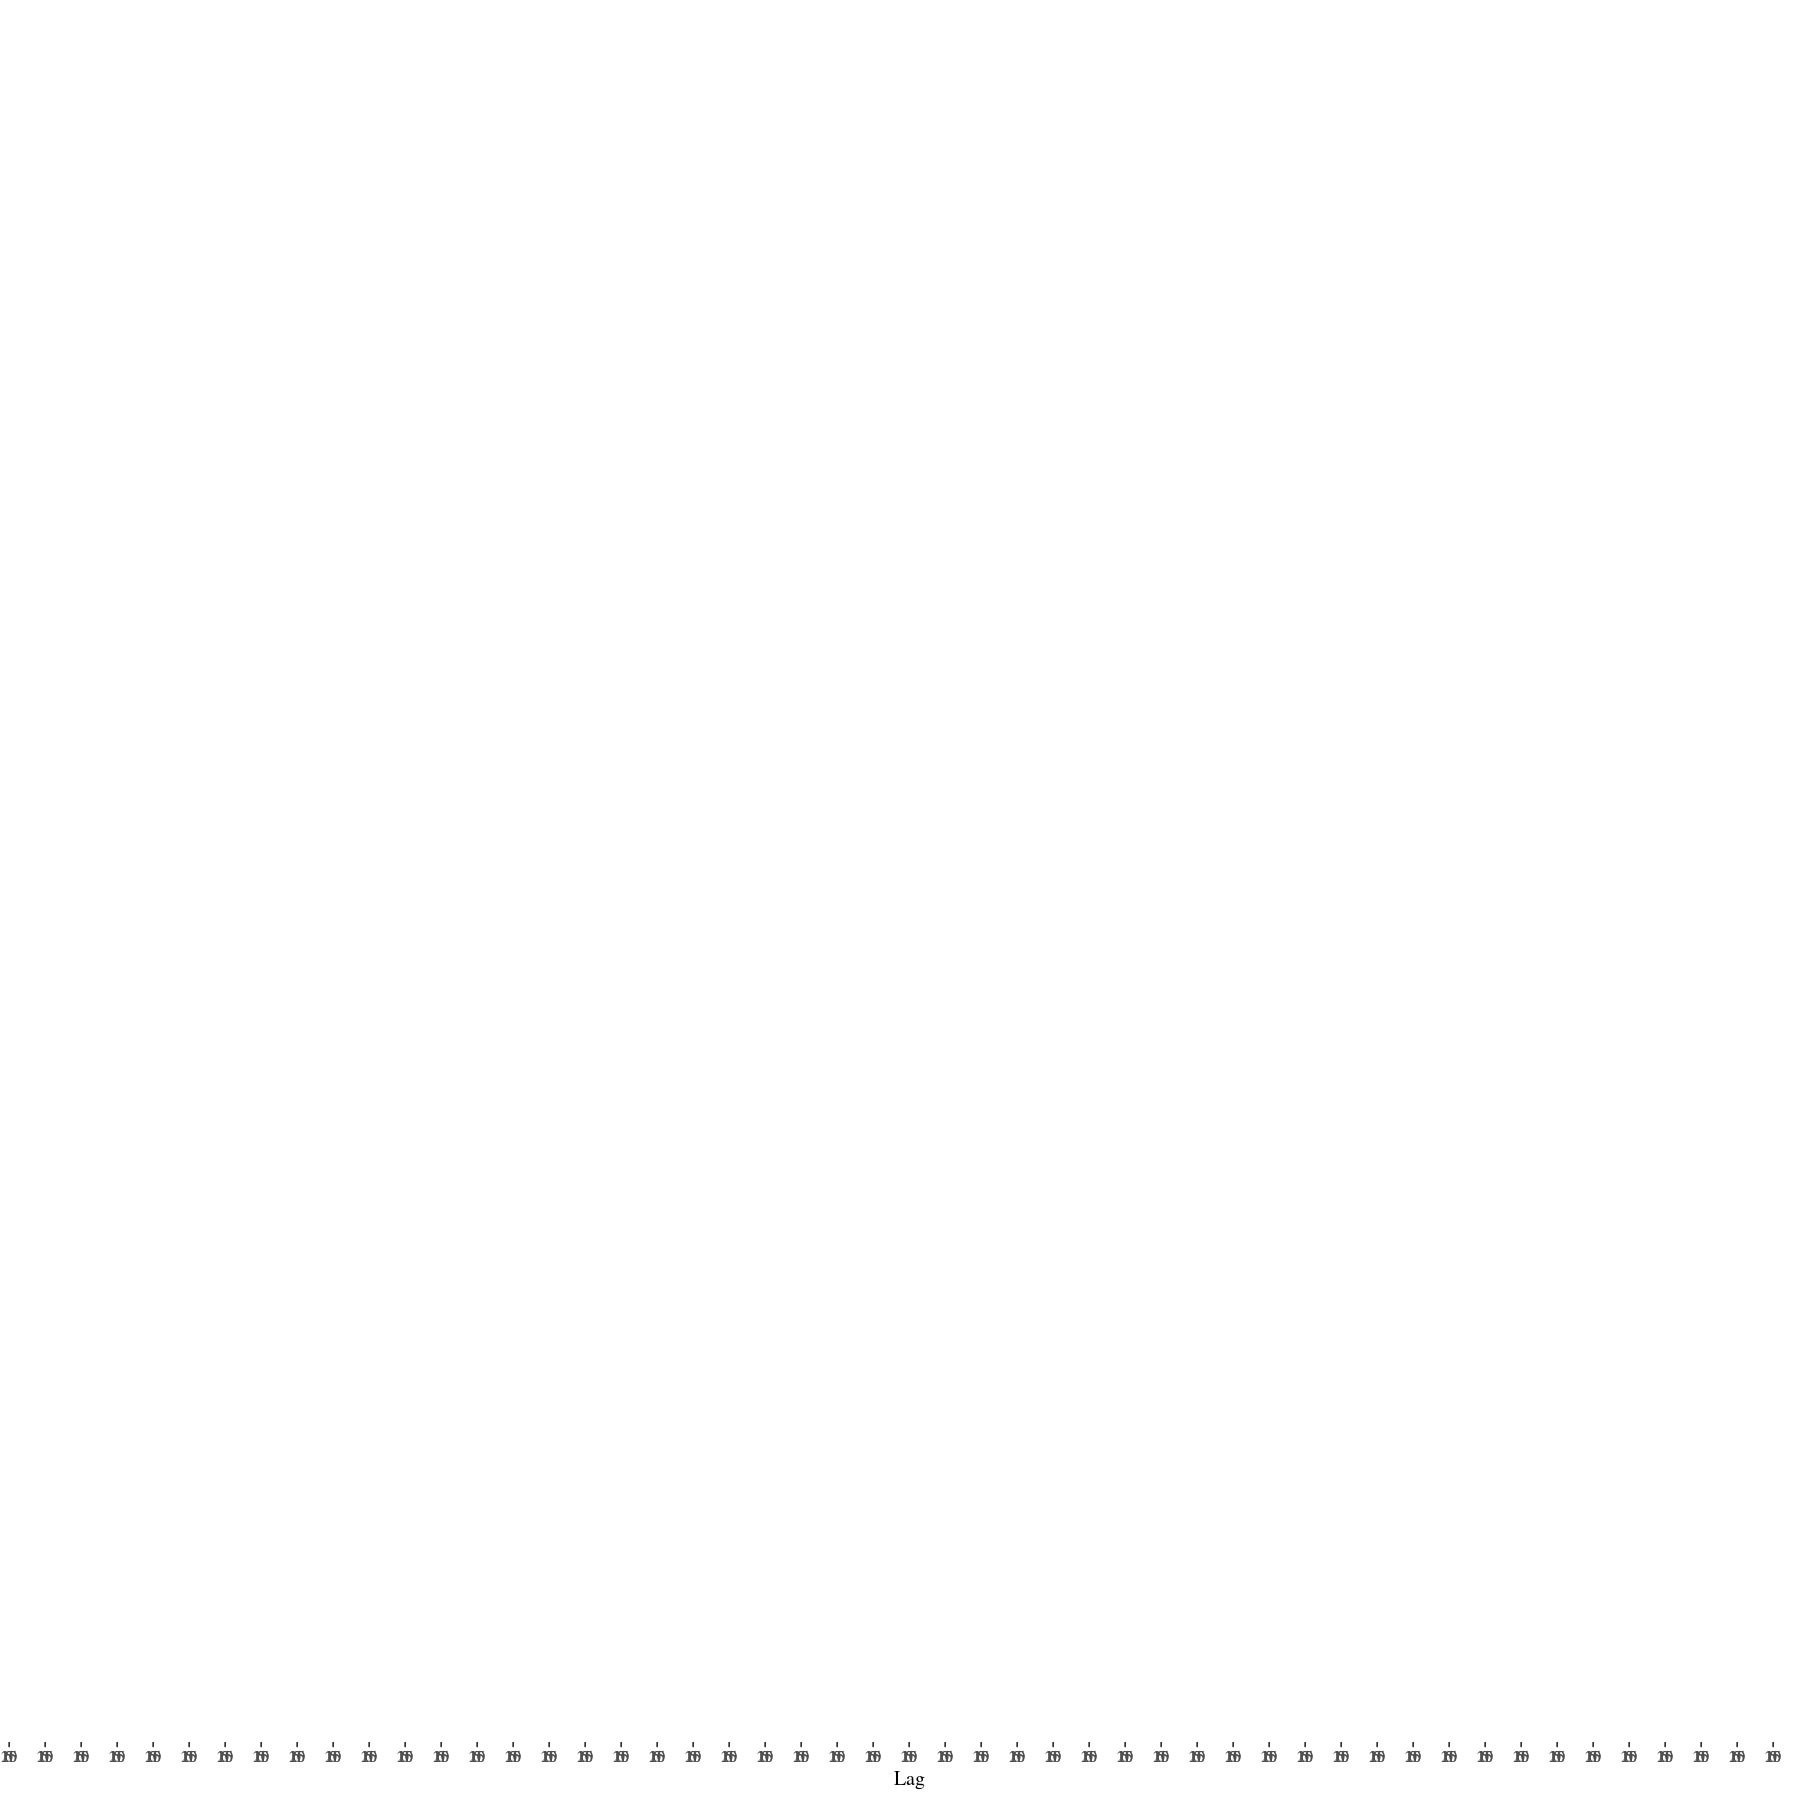

In [32]:
options(repr.plot.width=15, repr.plot.height=15)
mcmc_trace(bwc_model, size = 0.1)
mcmc_dens_overlay(bwc_model)
mcmc_acf(bwc_model)
neff_ratio(bwc_model)
rhat(bwc_model)

Looks good!

Posterior predictive check for entire model:

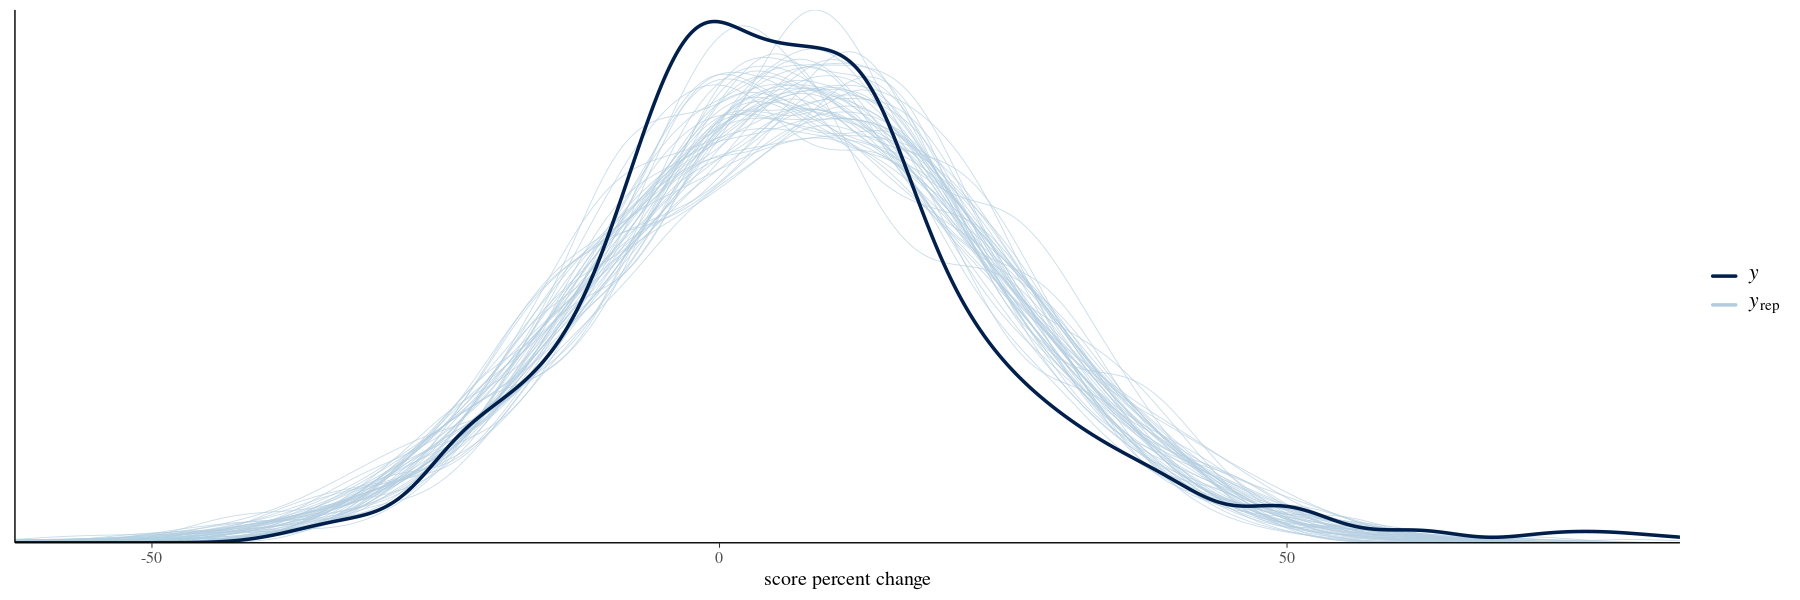

In [33]:
options(repr.plot.width=15, repr.plot.height=5)
pp_check(bwc_model) + xlab("score percent change")

Reasonable, although the normal does not capture the data distribution perfectly.

## Exercise 19.10

### a)

In [34]:
tidy(bwc_model, effects = "fixed", conf.int = TRUE, conf.level = 0.80)

term               estimate    std.error  conf.low    conf.high  
1 (Intercept)        17.61253771 6.46763770  9.43693441 25.81506041
2 age_months         -0.17189181 0.08883075 -0.28411372 -0.05867890
3 esl_observed        0.73754942 2.80741039 -2.83367186  4.34695532
4 treat1             -0.88277744 1.63783580 -2.97946784  1.23215486
5 private_school      0.89210981 3.07991282 -3.15180117  4.83356378
6 free_reduced_lunch  0.01817009 0.03533995 -0.02757163  0.06304653

Only `age_months` appears to be significant at the 80% level, with a large uncertainty. It appears that with each month of age, `score_pct_change` is reduced by 0.17.

### b)

In [35]:
tidy(bwc_model, effects = "ran_pars") %>% 
    mutate( squared=estimate^2, proportion=squared/sum(squared) ) %>% 
    select( -squared )
    

term                     group     estimate  proportion
1 sd_(Intercept).school_id school_id  2.509992 0.02033181
2 sd_Observation.Residual  Residual  17.423032 0.97966819

$\sigma_y=17.4$, $\sigma_b=2.5$. The variability between the students of a school clearly dominates the overall variability.

## Exercise 19.11

In [36]:
school_level_effects <- tidy(bwc_model, effects = "ran_vals", conf.int = TRUE, conf.level = 0.80)
head( school_level_effects )

level group     term        estimate   std.error conf.low   conf.high
1 1     school_id (Intercept) -0.2128394 1.595665  -3.2222516 1.9455620
2 2     school_id (Intercept)  0.9269347 1.816862  -0.8907846 4.6999950
3 3     school_id (Intercept)  0.8832702 1.820799  -0.9400862 4.6748250
4 4     school_id (Intercept)  0.1742617 1.596676  -2.0269883 3.0610136
5 5     school_id (Intercept)  0.3163362 1.607116  -1.6833285 3.4417448
6 6     school_id (Intercept) -1.2107841 2.042551  -5.5164243 0.6814634

### a)

In [37]:
school_level_effects %>% 
    filter( level == "30" )

level group     term        estimate  std.error conf.low  conf.high
1 30    school_id (Intercept) -1.591776 2.353159  -6.042635 0.3968267

Posterior median model: score_pct_change = 17.6 - 1.6 - 0.17 age_months =  16.0 - 0.17 age_months (reporting only significant coefficients)

### b)

In [38]:
school_level_effects %>% 
    filter( level == "47" )

level group     term        estimate std.error conf.low   conf.high
1 47    school_id (Intercept) 1.354891 2.144308  -0.5696326 5.652695

Posterior median model: score_pct_change = 17.6 + 1.4 - 0.17 age_months =  19.0 - 0.17 age_months (reporting only significant coefficients)

### c)

Posterior median model: score_pct_change = 17.6 - 0.17 age_months + 0.018 * 95 = 19.3 - 0.17 age_months 

(using the non-significant contribution of free_reduced_lunch)

### d)

Posterior median model: score_pct_change = 17.6 - 0.17 age_months + 0.018 * 10 = 17.8 - 0.17 age_months 

(using the non-significant contribution of free_reduced_lunch)

## Exercise 19.12

### a)

None at a significant level. Maybe with more data private_school, maybe also the availability of free or reduced lunch, however I do not see this directly.

### b)

The younger the student, the greater the vocabular improvement (at a significant level, yet with quite some uncertainty). Maybe with more data it also helps being an ESL student (to have more change / maybe a steeper learning curve).